# Sparkify Churn Prediction
### By: Jonathan Collier

### <a id='project_sections'>Project Sections</a>
- [Load and Clean Dataset](#load_and_clean_dataset)
- [Exploratory Data Analysis](#eda)
- [Feature Engineering](#feature_engineering)
- [Modeling](#modeling)

In [1]:
spark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1700153622758_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# Installing packages.
sc.install_pypi_package('pandas')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('seaborn')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import min as min_
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import col
from pyspark.sql.functions import count_distinct

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.feature import (
    OneHotEncoder, StringIndexer, VectorAssembler,
    RobustScaler, RFormula, PCA
)
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    LogisticRegressionModel,
    RandomForestClassificationModel,
    DecisionTreeClassificationModel,
    GBTClassificationModel
)

from pyspark.ml.tuning import (
    ParamGridBuilder,
    CrossValidator
)


# Adding custom sparkify package my cluster.
S3_BUCKET = 's3_bucket' # Replace with bucket where sparkify.zip is stored.
FOLDER = 'sparkify' # Replace with folder where sparkify.zip is stored.
FILE_NAME = 'sparkify.zip'
PACKAGE_PATH = f'{S3_BUCKET}/{FOLDER}/{FILE_NAME}'
sc.addPyFile(PACKAGE_PATH)


# Importing from classes and functions from sparkify package.
from sparkify.data_cleaning import DataCleaning
from sparkify.data_pipeline import DataPipeline
from sparkify.categorical_transformer import CategoricalTransformer
from sparkify.numeric_transformer import NumericTransformer
from sparkify.eda import (
    box_and_hist_plot_by_status, 
    bar_plot_by_status, 
    rc_params,
    get_status_counts_by_column
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# <a id='load_and_clean_dataset'>[Load and Clean Dataset</a>](#project_sections)
- [Loading event data from S3](#loading_dataset)
- [Checking for invalid data](#checking_invalid_data)
- [Cleaning event data](#cleaning_event_data)

### <a id='loading_dataset'>[Loading event data from S3</a>](#load_and_clean_dataset)

In [4]:
event_log_path = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
event_log = spark.read.json(event_log_path)
event_log.persist().count()

# Creating a temporary view of `event_log` DataFrame.
event_log.createOrReplaceTempView('event_log')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
event_log.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [6]:
# Total number of records.
spark.sql('''
SELECT COUNT(*) AS count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|   count|
+--------+
|26259199|
+--------+

In [7]:
# Total number of columns.
spark.sql('''
SHOW COLUMNS IN event_log
''').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

18

In [8]:
# What are the unique identifier of the dataset?
spark.sql('''
SELECT COUNT(DISTINCT userId, sessionId, itemInSession, ts) AS count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|   count|
+--------+
|26259199|
+--------+

### <a id='checking_invalid_data'>[Checking for invalid data (`userId`, `sessionId`, `itemInSessions`)</a>](#load_and_clean_dataset)

Checking for Null and Non-Numeric `sessionId`, `itemInSession`, and `userId` values.

In [9]:
spark.sql("""
SELECT 
    SUM(CASE WHEN CAST(sessionId AS INT) IS NULL THEN 1 ELSE 0 END) AS sessionId_count,
    SUM(CASE WHEN CAST(itemInSession AS INT) IS NULL THEN 1 ELSE 0 END) AS itemInSession_count,
    SUM(CASE WHEN CAST(userId AS INT) IS NULL THEN 1 ELSE 0 END) AS userId_count
FROM event_log
""").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-------------------+------------+
|sessionId_count|itemInSession_count|userId_count|
+---------------+-------------------+------------+
|              0|                  0|           0|
+---------------+-------------------+------------+

Checking if each user has exactly 1 `registration` date, i.e., if any user has a Null value
or multiple values for `registration` date.

In [10]:
spark.sql("""
    SELECT 
        SUM(
            IF(registration_date_count > 1, 1, 0) 
        ) AS multiple_registration_count,
        SUM(
            IF(registration_date_count = 0, 1, 0)
        ) AS null_registration_count
    FROM 
        (
        SELECT 
            userId, 
            COUNT(DISTINCT registration) AS registration_date_count 
        FROM event_log
        GROUP BY userId
        HAVING COUNT(DISTINCT registration) != 1
        )
""").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------+-----------------------+
|multiple_registration_count|null_registration_count|
+---------------------------+-----------------------+
|                          0|                      1|
+---------------------------+-----------------------+

Checking if any users have a `registration` date that is inconsistent
with their `ts` values. For example, if a user has a `registration` date past when the event data
shows they were interacting with the app.

In [11]:
spark.sql("""
    SELECT 
        COUNT(userId) AS invalid_registration_count
    FROM 
        (
        SELECT 
            userId, 
            FIRST_VALUE(registration) AS registration, 
            MAX(ts) AS min_user_ts
        FROM event_log
        GROUP BY userId
        HAVING FIRST_VALUE(registration) > MIN(ts)
        )
""").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+
|invalid_registration_count|
+--------------------------+
|                       144|
+--------------------------+

In [12]:
# Checking the range of the ts column.
spark.sql('''
SELECT 
    MIN(ts) As min_ts, 
    MAX(ts) AS max_ts, 
    SUM(CASE WHEN ts IS NULL THEN 1 ELSE 0 END) AS null_timestamp_count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------+--------------------+
|       min_ts|       max_ts|null_timestamp_count|
+-------------+-------------+--------------------+
|1538352001000|1543622402000|                   0|
+-------------+-------------+--------------------+

In [13]:
# Checking the range of the registration column.
spark.sql('''
SELECT 
    MIN(registration) As min_registration, 
    MAX(registration) AS max_registration, 
    SUM(CASE WHEN ts IS NULL THEN 1 ELSE 0 END) AS null_registration_count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------------+-----------------------+
|min_registration|max_registration|null_registration_count|
+----------------+----------------+-----------------------+
|   1508018725000|   1543821822000|                      0|
+----------------+----------------+-----------------------+

In [14]:
# Checking the number of users.
spark.sql('''
SELECT COUNT(DISTINCT userId) AS count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+
|count|
+-----+
|22278|
+-----+

In [15]:
# level column.
spark.sql('''
SELECT level, COUNT(DISTINCT userId) AS count
FROM event_log
GROUP BY level
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|level|count|
+-----+-----+
| free|18793|
| paid|16185|
+-----+-----+

In [16]:
# length column
spark.sql('''
SELECT
    FIRST_VALUE(length) AS sample_value, 
    MIN(length) AS min_value,
    MAX(length) AS max_value,
    SUM(CASE WHEN length IS NULL THEN 1 ELSE 0 END) AS null_count,
    SUM(CASE WHEN page = 'NextSong' AND length IS NULL THEN 1 ELSE 0 END) AS NextSong_page_null_count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+----------+----------+------------------------+
|sample_value|min_value| max_value|null_count|NextSong_page_null_count|
+------------+---------+----------+----------+------------------------+
|   524.32934|    0.522|3024.66567|   5408927|                       0|
+------------+---------+----------+----------+------------------------+

In [17]:
# gender column
spark.sql('''
SELECT gender, COUNT(DISTINCT userId) AS count
FROM event_log
GROUP BY gender 
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|gender|count|
+------+-----+
|     M|11651|
|     F|10626|
|  null|    1|
+------+-----+

In [18]:
# location column
spark.sql('''
SELECT 
    COUNT(DISTINCT location) AS distinct_location_count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+
|distinct_location_count|
+-----------------------+
|                    886|
+-----------------------+

In [19]:
# auth column
spark.sql('''
SELECT 
    auth,
    COUNT(*) AS count
FROM event_log
GROUP BY auth
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+
|      auth|   count|
+----------+--------+
|Logged Out|  774285|
|     Guest|    4194|
| Cancelled|    5003|
| Logged In|25475717|
+----------+--------+

In [20]:
# sessionId column
spark.sql('''
SELECT 
    COUNT(DISTINCT sessionId) AS distinct_count, 
    MIN(sessionId) AS min_session_id, 
    MAX(sessionId) AS max_session_id, 
    COUNT(DISTINCT userId, sessionId) AS distinct_user_session_count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------+--------------+---------------------------+
|distinct_count|min_session_id|max_session_id|distinct_user_session_count|
+--------------+--------------+--------------+---------------------------+
|        228713|             1|        240381|                     455178|
+--------------+--------------+--------------+---------------------------+

In [21]:
# itemInSession column
spark.sql('''
SELECT 
    COUNT(DISTINCT sessionId) AS distinct_count, 
    MIN(itemInSession) AS min_session_id, 
    MAX(itemInSession) AS max_session_id, 
    COUNT(DISTINCT userId, sessionId) AS distinct_user_session_count
FROM event_log
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------+--------------+---------------------------+
|distinct_count|min_session_id|max_session_id|distinct_user_session_count|
+--------------+--------------+--------------+---------------------------+
|        228713|             0|          1428|                     455178|
+--------------+--------------+--------------+---------------------------+

In [22]:
# method column
spark.sql('''
SELECT method, COUNT(*) AS method_count
FROM event_log
GROUP BY method
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------------+
|method|method_count|
+------+------------+
|   GET|     2389761|
|   PUT|    23869438|
+------+------------+

In [23]:
# status column
spark.sql('''
SELECT status, COUNT(*) AS status_count
FROM event_log
GROUP BY status
''').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------------+
|status|status_count|
+------+------------+
|   200|    23811992|
|   404|       25962|
|   307|     2421245|
+------+------------+

In [24]:
# userAgent column
event_log.select('userAgent').distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|           userAgent|
+--------------------+
|Mozilla/5.0 (X11;...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (iPh...|
|Mozilla/5.0 (Maci...|
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (iPa...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows

### <a id='cleaning_event_data'>[Cleaning event data</a>](#load_and_clean_dataset)
- Using `DataCleaning` class in the `sparkify` package to:
    - Drop invalid users, i.e., users with a null or empty `userId`.
    - Drop users with invalid registration, i.e., where a users `registration` date
    doesn't align with their timestamps (`ts` values) using the Sparkify application.
    - Drop users with a null `registration` date.
    - Convert `ts` (timestamp values) to datetime and assign results to new column `dt`.
    - Convert `registration` (timestamp values) to datetime.

In [6]:
# Instantiating the DataCleaning class.
data_cleaning = DataCleaning(
    spark=spark
)

event_log = (
    event_log
    .transform(data_cleaning.drop_invalid_users)
    .transform(data_cleaning.drop_users_with_invalid_registration)
    .transform(data_cleaning.drop_users_with_null_registration)
    .transform(data_cleaning.convert_ts_to_datetime)
    .transform(data_cleaning.convert_registration_to_datetime)
)

# Replacing the temporary view `event_log`.
event_log.createOrReplaceTempView('event_log')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### General Info:
- The data contains user events on Sparkify, a fictional music streaming service, the data consists of user actions while interacting with the app. Each event has a timestamp, sessionId, userId, and itemInSession. 
- There 22,278 unique userIds. 
- The dataset has 26,259,199 samples and 18 columns. 
- Rows are uniquely identified by 'userId', 'sessionId', 'itemInSession', and 'ts'.

### Unique identifiers:
- <b><i>itemInSession</i></b>
    - Represents the count of the item in the session.
- <b><i>userId</i></b>
    - represents the unique identifier of the user.
- <b><i>sessionId</i></b>
    - Represents the unique identifier of the session.


### Features:

#### Categorical
- <b><i>page</i></b>
    - Assumes one of multiple possible values: ('Cancel', 'Submit Downgrade', 'Add Friend', 'Thumbs Up', 'Add to Playlist', 'Upgrade',   'Submit Upgrade', 'Cancellation Confirmation', 'Settings', 'Save Settings', 'Error', 'Roll Advert', 'Submit Registration')
- <b><i>gender</i></b>
    - Assumes one of three possible values: ('M', 'F' or 'null').
    - The value counts are 'M': 11651, 'F': 10626, and 'null': 1.
- <b><i>auth</i></b>
    - Assumes one of four possible values: ('Logged In', 'Logged Out', 'Guest' or 'Cancelled') 
    - The value counts are 'Logged Out': 774285, 'Guest': 4194, 'Cancelled': 5003 and 'Logged In': 25475717.
- <b><i>location</i></b>
    - Assumes multiple values: generally in the format (city, state code).
    - Distinct location count: 886.
- <b><i>userAgent</i></b>
    - Assumes multiples values
    - Includes details regarding whether the user is using a computer/cellphone, what kind of operating system the user is on including version, what kind of browser, etc.
- <b><i>level</i></b>
    - Assumes one of two possible values ('paid' or 'free')
    - The value counts are 'paid': 16185 and 'free': 18793.
    - Users are switching between paid and free accounts throughout their time as a customer. Users switch levels via a Submit Downgrade or Submit Upgrade event.
- <b><i>method</i></b>
    - Assumes one of two possible values: ('PUT' or 'GET')
    - The value counts are 'PUT': 23,869,438 and 'GET': 2,389,761.
    - The methods correspond to: 'GET': data retrieval and 'PUT': creates a new resource or replaces a representation of the target resource.
- <b><i>status</i></b>
    - Assumes one of three possible values: (307, 404, or 200)
    - The value counts are 307: 2,421,245, 404: 25,962, and 200: 23,811,992.
    - The status codes correspond to: 307: Temporary Redirect, 200: Successful Response, and 404: Client Error Response.
- <b><i>firstName</i></b>
    - Corresponds to the first name of the user.
- <b><i>lastName</i></b>
    - Corresponds to the last name of the user.
- <b><i>artist</i></b>
    - Assumes multiple values.
    - Represents the name of the artist.
- <b><i>song</i></b>
    - Assumes multiple values
    - Represents the name of the song.

#### Continuous
- <b><i>length</i></b>
    - Values range from 0.522 and 3024.66567.
    - values are Null when 'page' is not equal to NextSong.
- <b><i>ts</i></b>
    - Values range from 1538352001000 to 1543622402000.
    - Values range from 2018-10-01 00:00:01 to 2018-12-01 00:00:02
- <b><i>registration</i></b>
    - Values range from 1508018725000 to 1543821822000 
    - Values range from 2017-10-14 22:05:25 to 2018-12-03 07:23:42

# <a id='eda'>[Exploratory Data Analysis</a>](#project_sections)

- [Churn Definition](#churn_definition)
- [Running `DataPipeline`](#running_data_pipeline)
- [Creating subset of `user_data`](#creating_subset_of_user_data)
- [Creating EDA plots](#eda_plots)
- [EDA Summary](#eda_summary)

### <a id="churn_definition">[Churn Definition</a>](#eda)
- I am defining churn as `Cancellation Confirmation` events, if a user has a `Cancellation Confirmation` in the event data, the transformed spark DataFrame will have `1` marked in the `churn` column, otherwise, it will have a value of `0`. Therefore, this will be modeled a binary classification problem where the aim is to predict which users will churn given features transformed from the `event_log` data. 

- <b>Note:</b> For the purpose of eda, I will use a column called `status` as a stand in for `churn` which will have values `Cancelled` and `Active`.

### <a id='running_data_pipeline'>[Running `DataPipeline`</a>](#eda)
- Using `DataPipeline` to:
    - Transform `event_log` data into features and consolidate into a spark DataFrame called `user_data`
    - The transformed DataFrame will be used for Exploratory Data Analysis and Modeling.

In [7]:
data_pipeline = DataPipeline(
    spark=spark
)

# Transforming the event log into a DataFrame where 
# each row contains a unique user along with 
# the users aggregated data from the event log.
user_data = data_pipeline.run(event_log)
user_data.persist().count()

# Creating a temp view for `user_data` DataFrame.
user_data.createOrReplaceTempView('user_data')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <a id ='creating_subset_of_user_data'>[Creating a subset of `user_data`</a>](#eda)
- Taking a sample of 30% of `user_data` without replacement for EDA.

In [7]:
# Looking at a subset of user_data for EDA.
user_data_subset = user_data.sample(
    withReplacement=False, 
    fraction=0.3, 
    seed=42
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

###  <a id='eda_plots'>[Creating EDA Plots</a>](#eda)
- [Class Imbalance](#class_imbalance)
- [User Cohort By Status](#cohort)
- [User Days Registered By Status](#days_registered)
- [User Proportion of Days Active By Status](#proportion_days_active)
- [User Gender By Status](#gender)
- [User Last Level By Status](#last_level)
- [User Browser By Status](#browser)
- [User Operating System By Status](#operating_system)
- [User Device Type By Status](#device_type)
- [User Next Songs Per Day By Status](#next_songs)
- [User Next Songs Per Day (Last 7 Days) By Status](#next_songs_last_7d)
- [User Session Hours Per Day By Status](#session_hours)
- [User Upgrades Per Day By Status](#upgrades)
- [User Upgrades Per Day (Last 7 Days) By Status](#upgrades_last_7d)
- [User Downgrades Per Day By Status](#downgrades)
- [User Downgrades Per Day (Last 7 Days) By Status](#downgrades_last_7d)
- [User Submitted Upgrades Per Day By Status](#submitted_upgrades)
- [User Submitted Upgrades Per Day (Last 7 Days) By Status](#submitted_upgrades)
- [User Submitted Downgrades Per Day By Status](#submitted_downgrades)
- [User Submitted Downgrades Per Day (Last 7 Days) By Status](#submitted_downgrades_last_7d)
- [User Rolled Advertisements Per Day By Status](#rolled_adverts)
- [User Rolled Advertisements Per Day (Last 7 Days) By Status](#rolled_adverts_last_7d)
- [User Errors Per Day By Status](#errors)
- [User Errors Per Day (Last 7 Days) By Status](#errors_last_7d)
- [User Help Per Day By Status](#help)
- [User Help Per Day (Last 7 Days) By Status](#help_last_7d)
- [User Add To Playlist Per Day By Status](#add_to_playlist)
- [User Add To Playlist Per Day (Last 7 Days) By Status](#add_to_playlist_last_7d)
- [User Thumbs Up Per Day By Status](#thumbs_up)
- [User Thumbs Up Per Day (Last 7 Days) By Status](#thumbs_up_last_7d)
- [User Thumbs Down Per Day By Status](#thumbs_down)
- [User Thumbs Down Per Day (Last 7 Days) By Status](#thumbs_down_last_7d)
- [User Settings Per Day By Status](#settings)
- [User Settings Per Day (Last 7 Days) By Status](#settings_last_7d)
- [User Save Settings Per Day By Status](#save_settings)
- [User Save Settings Per Day (Last 7 Days) By Status](#save_settings_last_7d)
- [User About Per Day By Status](#about)
- [User About Per Day (Last 7 Days) By Status](#about_last_7d)
- [User Added Friends Per Day By Status](#added_friends)
- [User Added Friends Per Day (Last 7 Days) By Status](#added_friends_last_7d)
- [User Sessions Per Day By Status](#sessions)
- [User Sessions Per Day (Last 7 Days) By Status](#sessions_last_7d)
- [User Home Per Day By Status](#home)
- [User Home Per Day (Last 7 Days) By Status](#home_last_7d)
- [User Logouts Per Day By Status](#logouts)
- [User Logouts Per Day (Last 7 Days) By Status](#logouts_last_7d)
- [User Thumbs Up Per Next Song By Status](#thumbs_up_per_next_song)
- [User Thumbs Up Per Next Song (Last 7 Days) By Status](#thumbs_up_per_next_song_last_7d)
- [User Thumbs Down Per Next Song By Status](#thumbs_down_per_next_song)
- [User Thumbs Down Per Next Song (Last 7 Days) By Status](#thumbs_down_per_next_song_last_7d)
- [User Add To Playlist Per Next Song By Status](#add_to_playlist_per_next_song)
- [User Add To Playlist Per Next Song (Last 7 Days) By Status](#add_to_playlist_per_next_song_last_7d)
- [User Rolled Adverts Per Next Song By Status](#rolled_adverts_per_next_song)
- [User Rolled Adverts Per Next Song (Last 7 Days) By Status](#rolled_adverts_per_next_song_last_7d)
- [Paid Days Active Per Days Active By Status](#paid_days_active_per_days_active)
- [Free Days Active Per Days Active By Status](#free_days_active_per_days_active)

In [8]:
# Setting theme for plotting.
sns.set_theme(
    palette=['#1D7E9E', '#E32227'], 
    rc=rc_params
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <a id='class_imbalance'>[Class Imbalance</a>](#eda_plots)

In [94]:
spark.sql("""
    SELECT 
        SUM(IF(churn = 1, 1, 0))/COUNT(*) AS churn_users_pct,
        SUM(IF(churn = 0, 1, 0))/COUNT(*) AS non_churn_users_pct
    FROM user_data
""").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+
|    churn_users_pct|non_churn_users_pct|
+-------------------+-------------------+
|0.22488816592110614| 0.7751118340788938|
+-------------------+-------------------+

### <a id='cohort'>[User Cohort By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

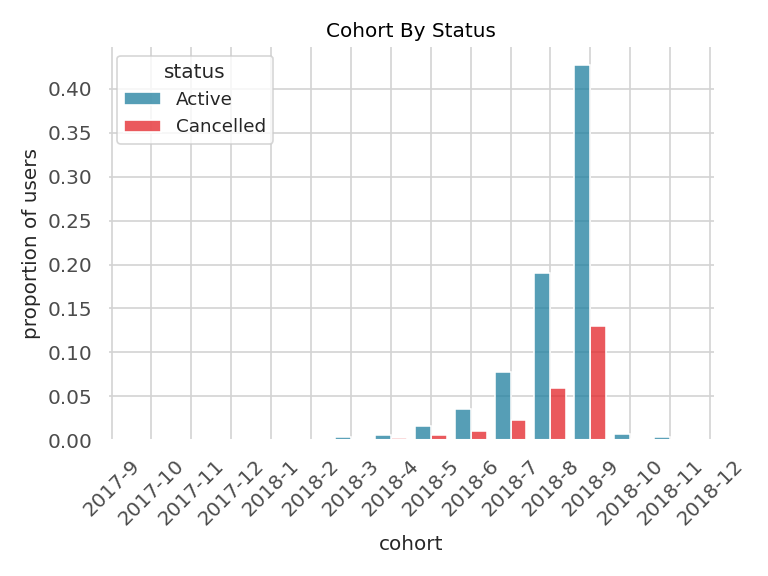

In [14]:
bar_plot_by_status(
    data=user_data_subset, 
    column='cohort',
    order=[
        '2017-9', '2017-10','2017-11',
        '2017-12', '2018-1', '2018-2',
        '2018-3', '2018-4', '2018-5',
        '2018-6', '2018-7', '2018-8',
        '2018-9', '2018-10', '2018-11',
        '2018-12'
    ]
)
plt.xticks(rotation=45)
plt.tight_layout()
%matplot plt

In [15]:
get_status_counts_by_column(
    data=user_data_subset, 
    column='registration',
    is_datetime=True
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

registration  registration  status   
2017          10            Active       1.000000
              12            Active       0.750000
                            Cancelled    0.250000
2018          1             Active       0.750000
                            Cancelled    0.250000
              2             Active       0.666667
                            Cancelled    0.333333
              3             Active       0.727273
                            Cancelled    0.272727
              4             Active       0.689655
                            Cancelled    0.310345
              5             Active       0.750000
                            Cancelled    0.250000
              6             Active       0.776699
                            Cancelled    0.223301
              7             Active       0.769572
                            Cancelled    0.230428
              8             Active       0.763158
                            Cancelled    0.236842
            

### <a id='days_registered'>[User Days Registered By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

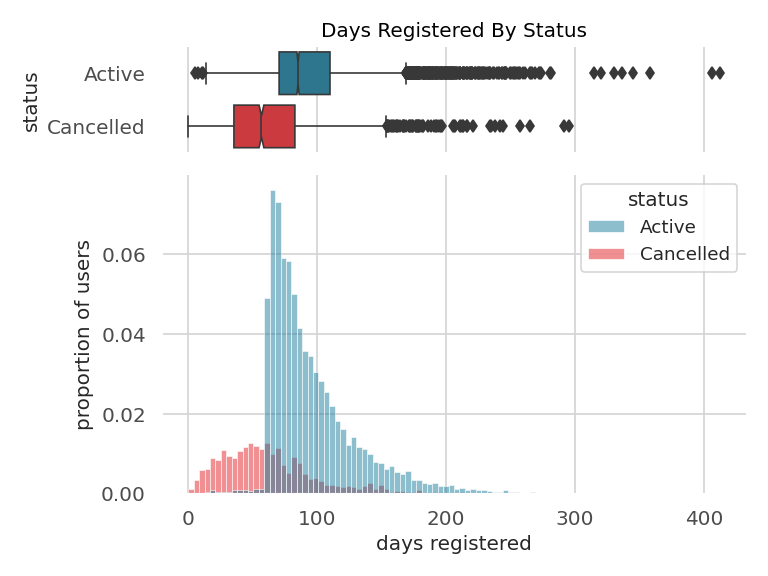

In [16]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='days_registered')
%matplot plt

### <a id='proportion_days_active'>[User Proportion of Days Active By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

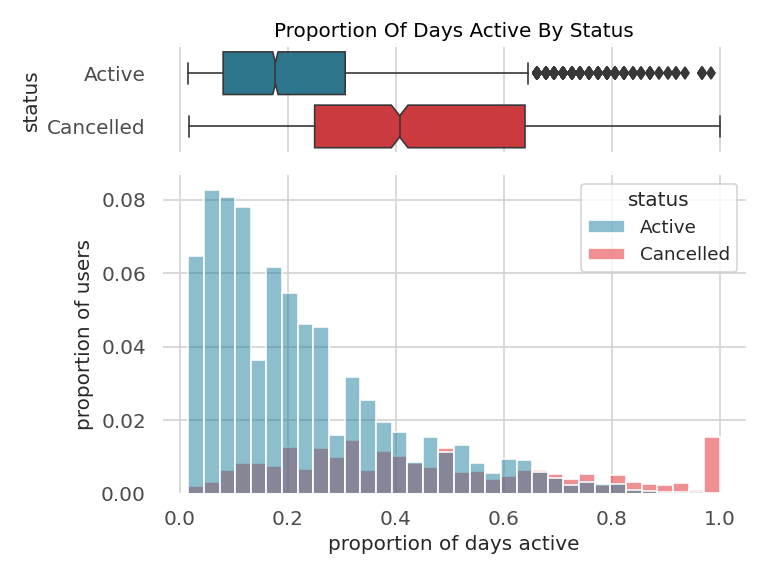

In [17]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='proportion_of_days_active'
)
%matplot plt

### <a id='gender'>[User Gender By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

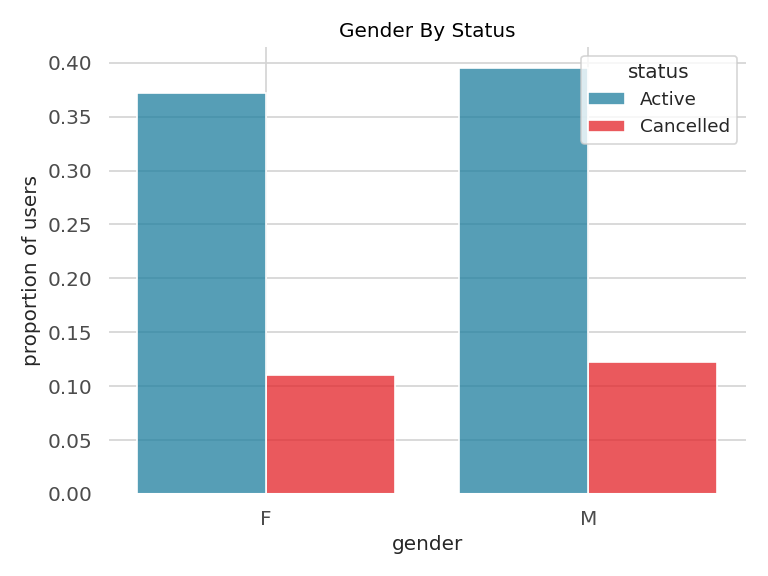

In [19]:
bar_plot_by_status(
    data=user_data_subset, 
    column='gender'
)
%matplot plt

In [20]:
get_status_counts_by_column(
    data=user_data_subset, 
    column='gender'
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

gender  status   
F       Active       0.771014
        Cancelled    0.228986
M       Active       0.763014
        Cancelled    0.236986
Name: status, dtype: float64

### <a id='last_level'>[User Last Level By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

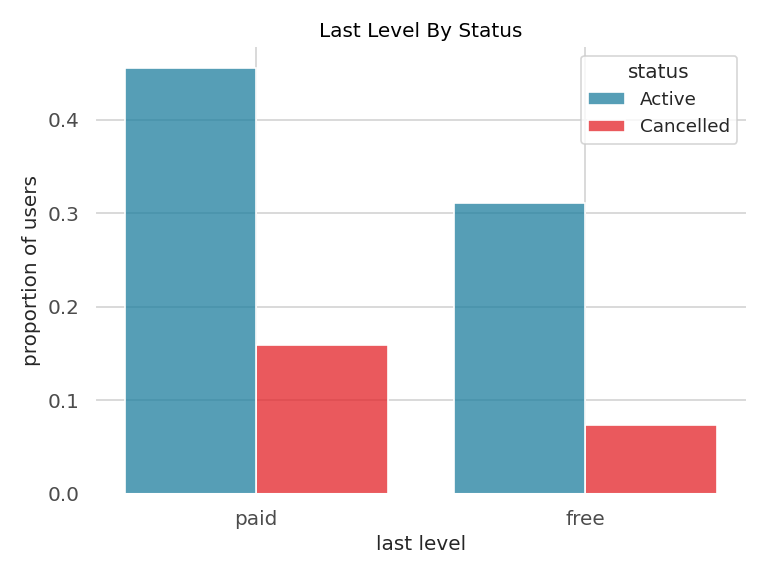

In [21]:
bar_plot_by_status(
    data=user_data_subset,
    column='last_level'
)
%matplot plt

In [22]:
get_status_counts_by_column(
    data=user_data_subset, 
    column='last_level'
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

last_level  status   
free        Active       0.808124
            Cancelled    0.191876
paid        Active       0.741037
            Cancelled    0.258963
Name: status, dtype: float64

### <a id='browser'>[User Browser By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

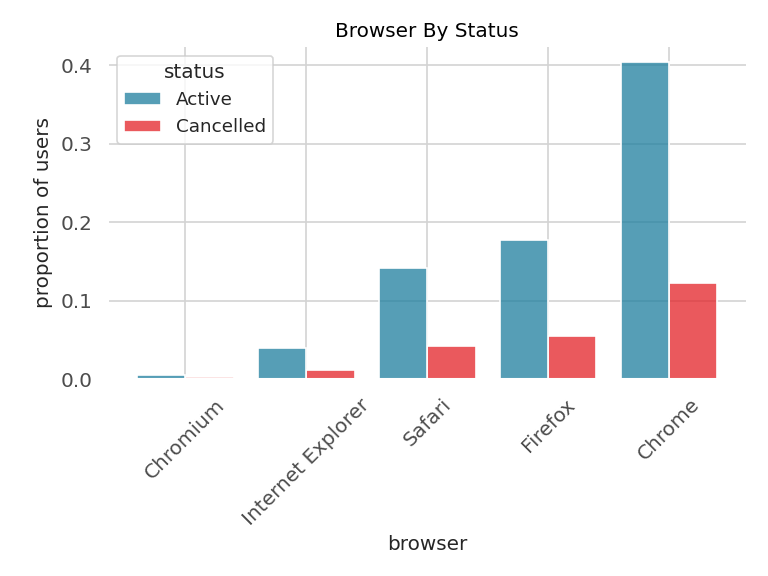

In [23]:
bar_plot_by_status(
    data=user_data_subset, 
    column='browser',
    order=[
        'Chromium',
        'Internet Explorer',
        'Safari',
        'Firefox',
        'Chrome'
    ]

)
plt.xticks(rotation=45)
plt.tight_layout()
%matplot plt

In [24]:
get_status_counts_by_column(
    data=user_data_subset, 
    column='browser'
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

browser            status   
Chrome             Active       0.767640
                   Cancelled    0.232360
Chromium           Active       0.629630
                   Cancelled    0.370370
Firefox            Active       0.763344
                   Cancelled    0.236656
Internet Explorer  Active       0.781341
                   Cancelled    0.218659
Safari             Active       0.771104
                   Cancelled    0.228896
Name: status, dtype: float64

### <a id='operating_system'>[User Operating System By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

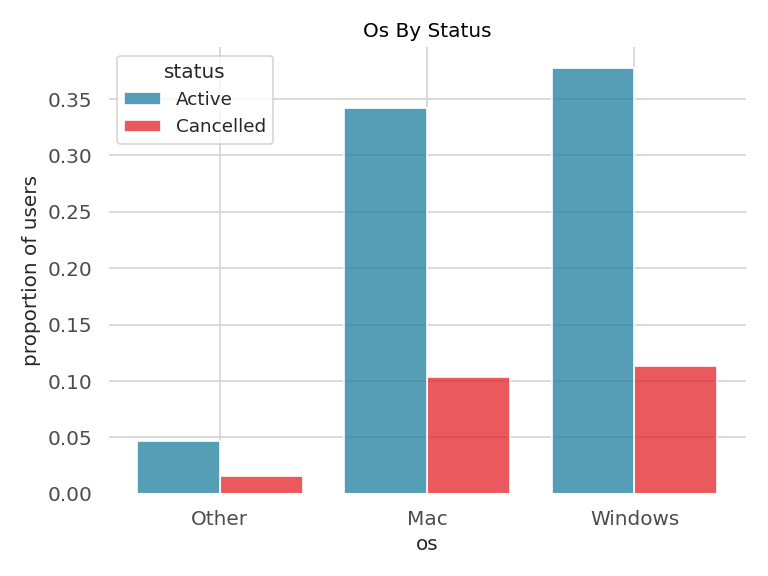

In [25]:
bar_plot_by_status(
    data=user_data_subset, 
    column='os',
    order=[
        'Other',
        'Mac',
        'Windows'
    ]
)
%matplot plt

In [28]:
get_status_counts_by_column(
    data=user_data_subset, 
    column='os'
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

os       status   
Mac      Active       0.766945
         Cancelled    0.233055
Other    Active       0.747045
         Cancelled    0.252955
Windows  Active       0.769347
         Cancelled    0.230653
Name: status, dtype: float64

### <a id='device_type'>[User Device Type By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

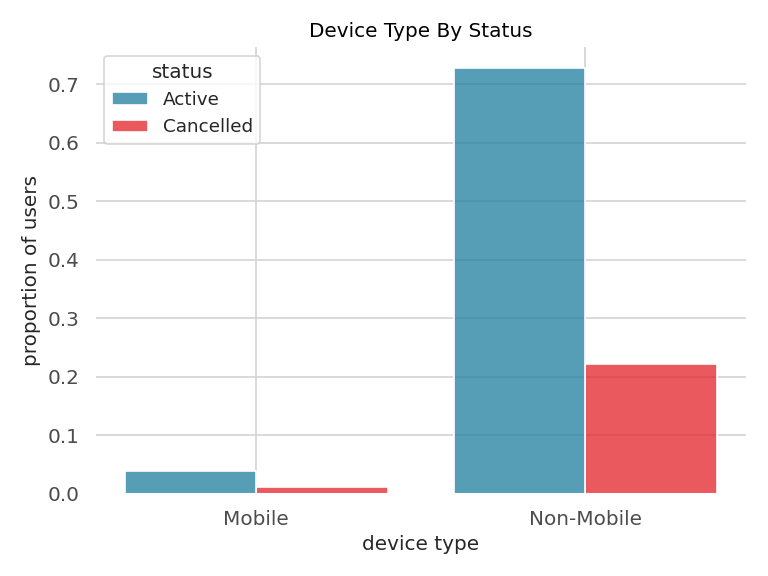

In [29]:
bar_plot_by_status(
    data=user_data_subset, 
    column='device_type',
    order=[
        'Mobile',
        'Non-Mobile'
    ]
)
%matplot plt

In [31]:
get_status_counts_by_column(
    data=user_data_subset, 
    column='device_type'
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

device_type  status   
Mobile       Active       0.777778
             Cancelled    0.222222
Non-Mobile   Active       0.766301
             Cancelled    0.233699
Name: status, dtype: float64

### <a id='next_songs'>[User Next Songs Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

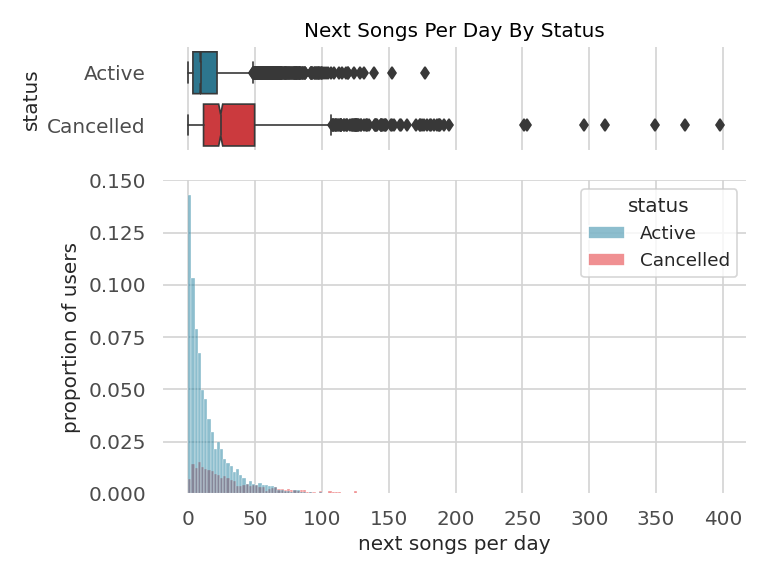

In [32]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='next_songs_per_day'
)
%matplot plt

### <a id='next_songs_last_7d'>[User Next Songs Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

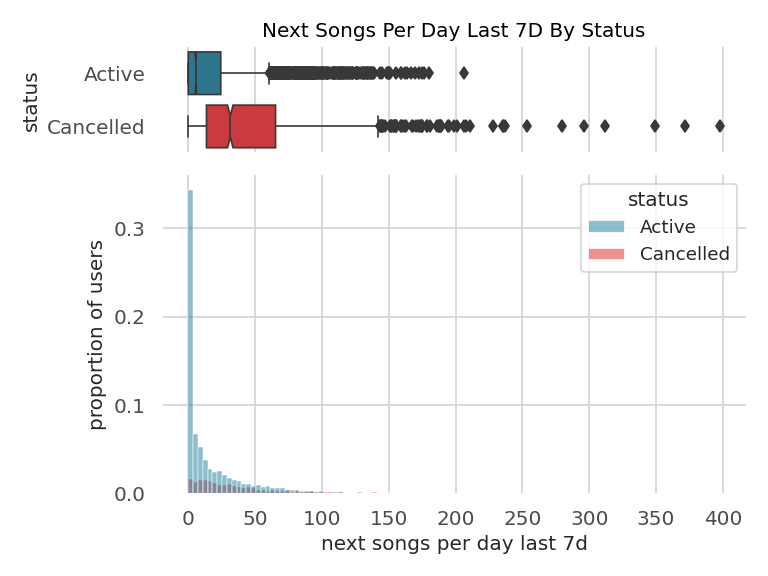

In [33]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='next_songs_per_day_last_7d'
)
%matplot plt

### <a id='session_hours'>[User Session Hours Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

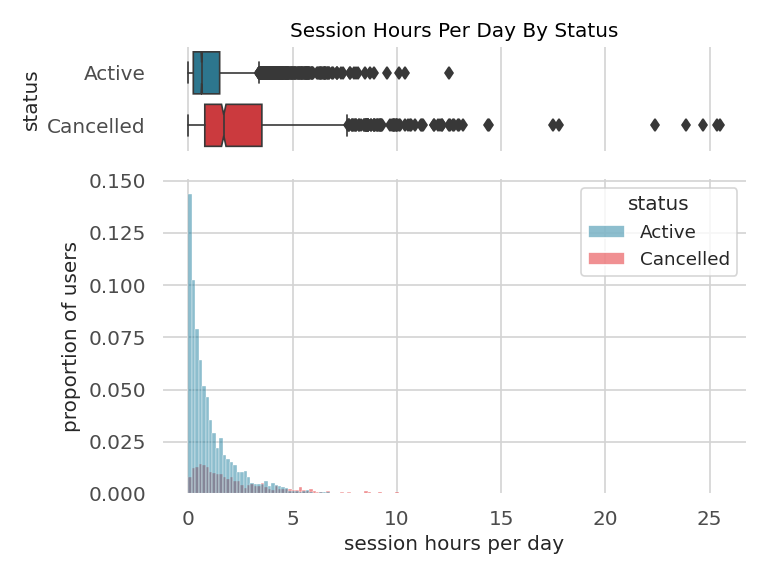

In [34]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='session_hours_per_day'
)
%matplot plt

### <a id='upgrades'>[User Upgrades Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

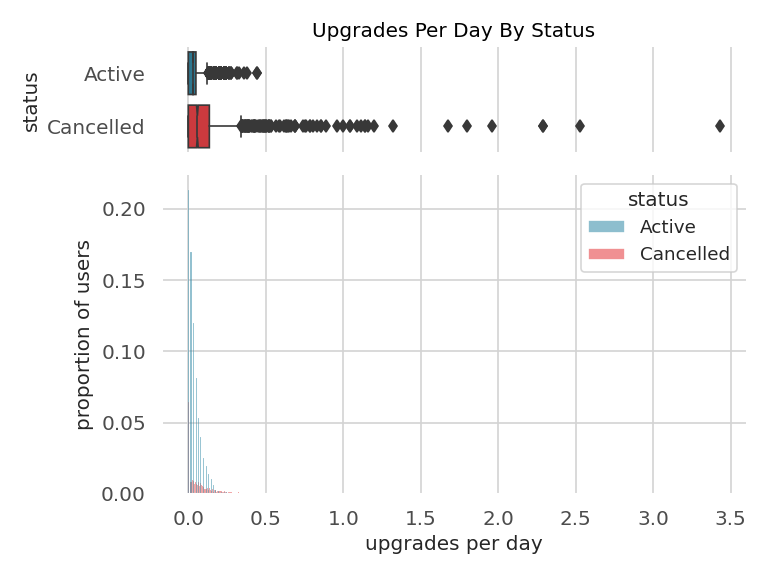

In [35]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='upgrades_per_day'
)
%matplot plt

### <a id='upgrades_last_7d'>[User Upgrades Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

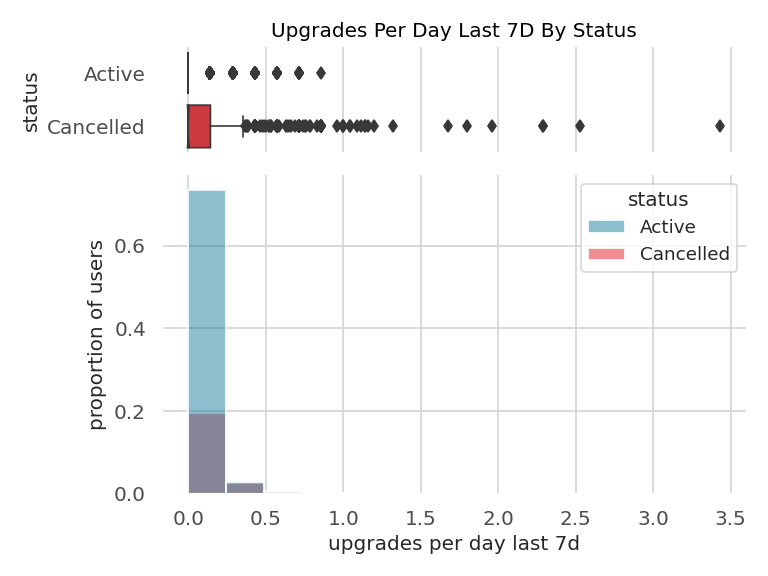

In [38]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='upgrades_per_day_last_7d'
)
%matplot plt

### <a id='downgrades'>[User Downgrades Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

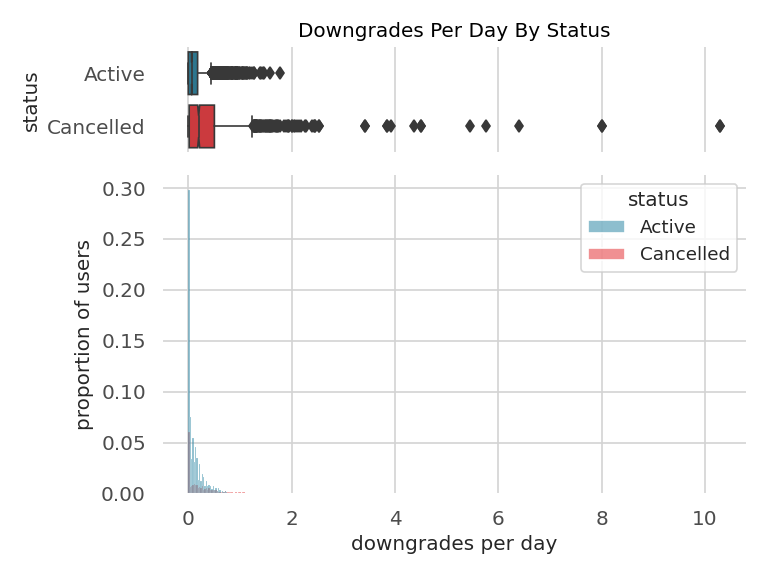

In [39]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='downgrades_per_day'
)
%matplot plt

### <a id='downgrades_last_7d'>[User Downgrades Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

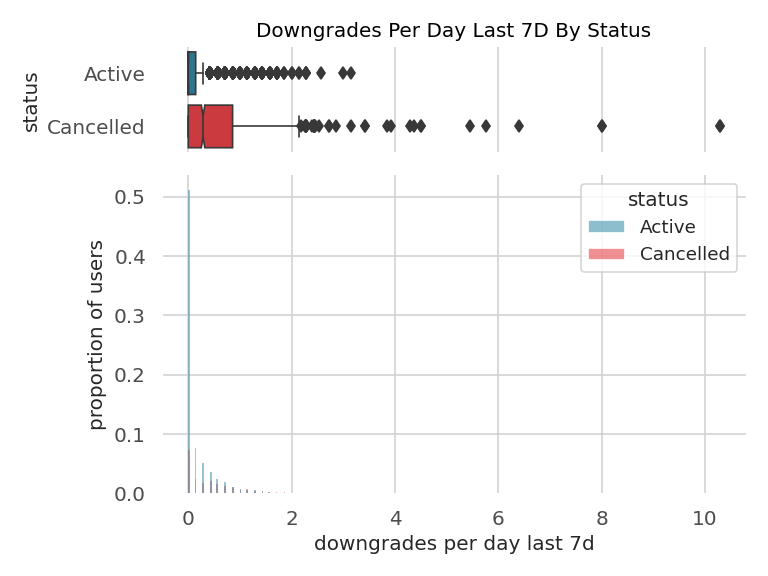

In [40]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='downgrades_per_day_last_7d'
)
%matplot plt

### <a id='submitted_upgrades'>[User Submitted Upgrades Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

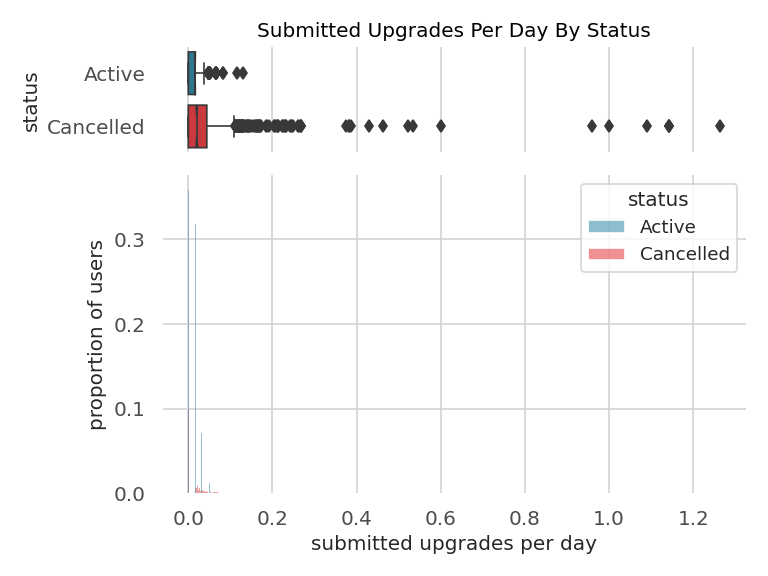

In [42]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='submitted_upgrades_per_day'
)
%matplot plt

### <a id='submitted_upgrades_last_7d'>[User Submitted Upgrades Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

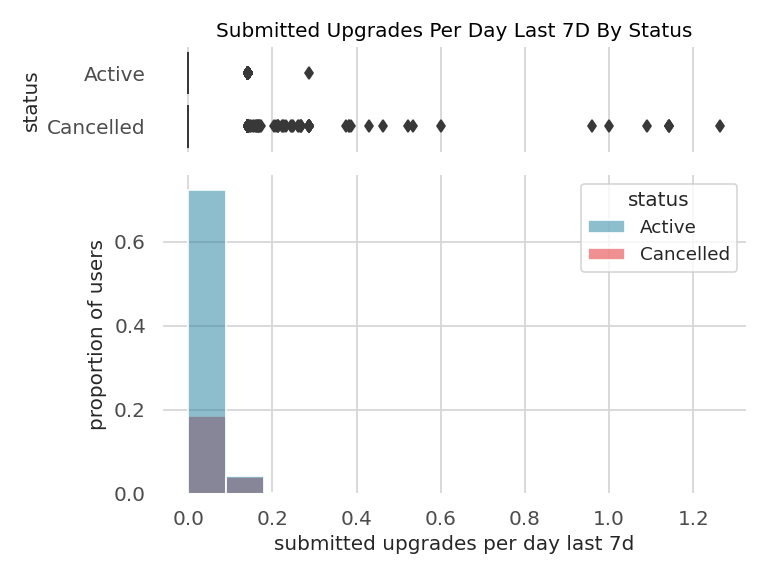

In [46]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='submitted_upgrades_per_day_last_7d'
)
%matplot plt

### <a id='submitted_downgrades'>[User Submitted Downgrades Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

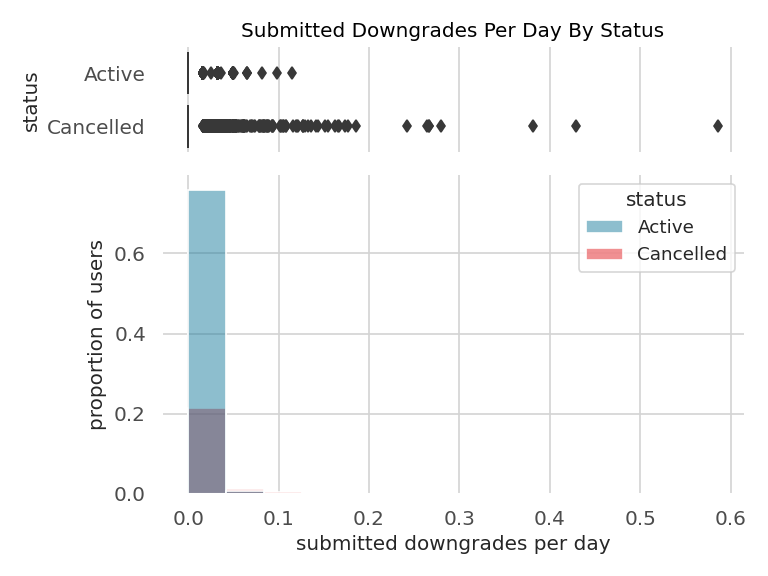

In [47]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='submitted_downgrades_per_day'
)
%matplot plt

### <a id='submitted_downgrades_last_7d'>[User Submitted Downgrades Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

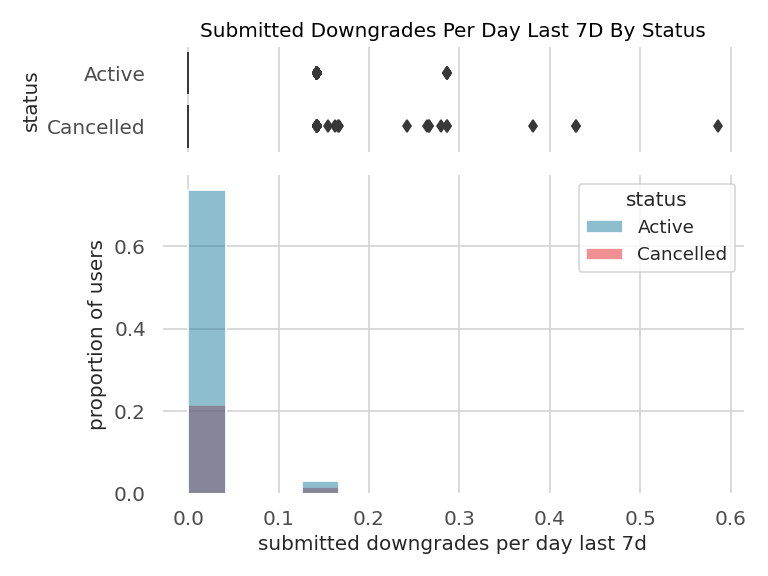

In [48]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='submitted_downgrades_per_day_last_7d'
)
%matplot plt

### <a id='rolled_adverts'>[User Rolled Advertisements Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

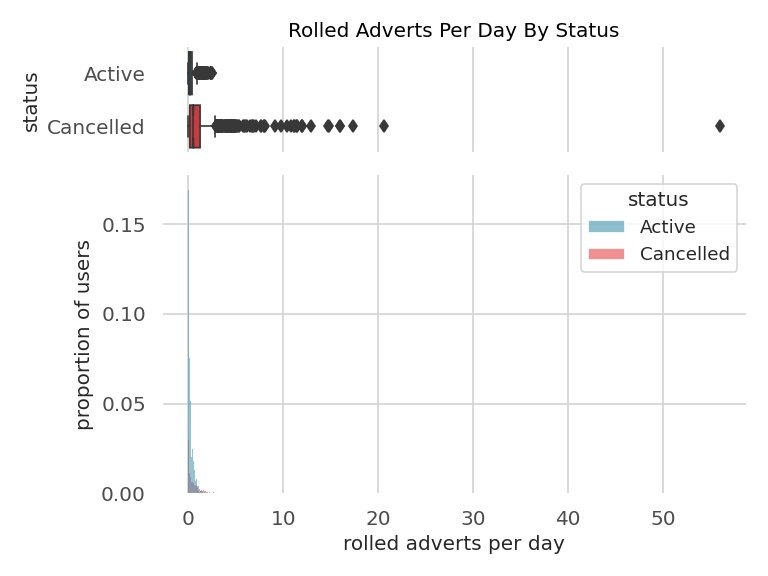

In [49]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='rolled_adverts_per_day'
)
%matplot plt

### <a id='rolled_adverts_last_7d'>[User Rolled Advertisements Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

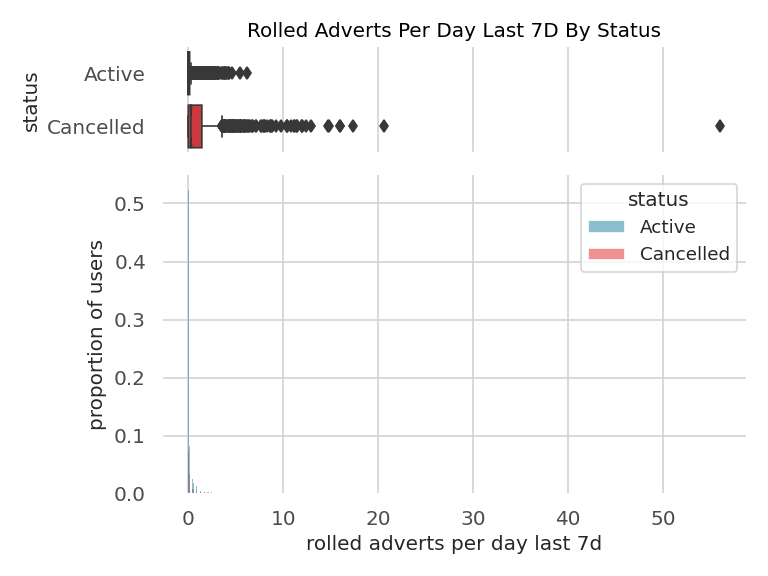

In [50]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='rolled_adverts_per_day_last_7d'
)
%matplot plt

### <a id='errors'>[User Errors Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

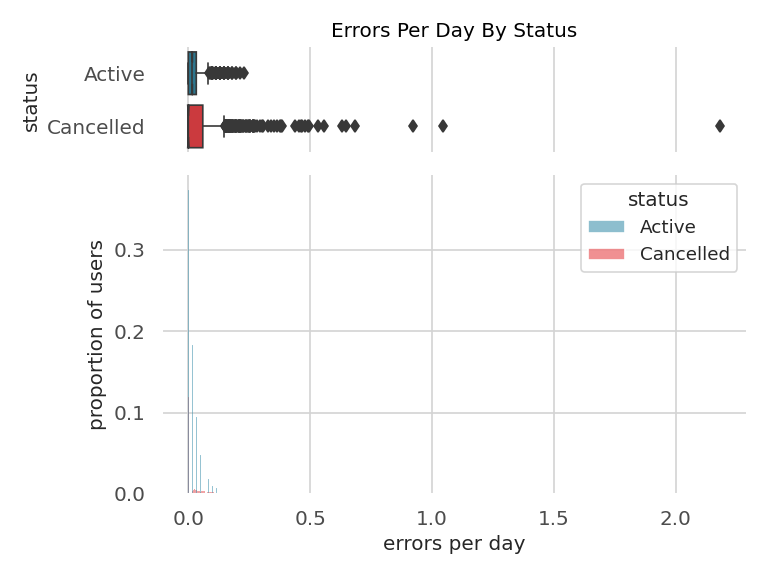

In [51]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='errors_per_day'
)
%matplot plt

### <a id='errors_last_7d'>[User Errors Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

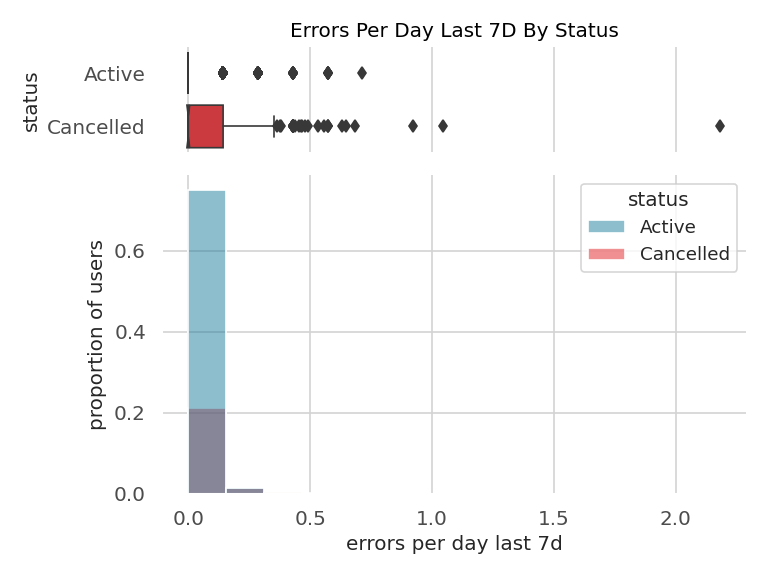

In [52]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='errors_per_day_last_7d'
)
%matplot plt

### <a id='help'>[User Help Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

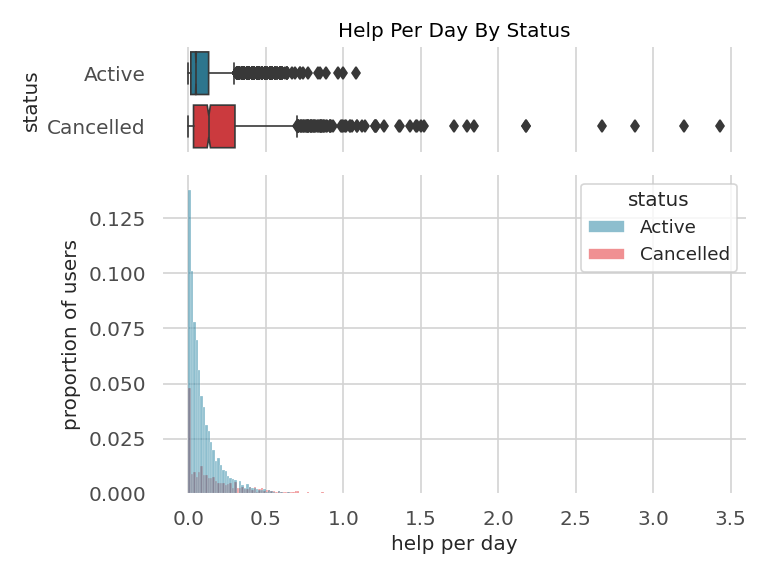

In [53]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='help_per_day'
)
%matplot plt

### <a id='help_last_7d'>[User Help Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

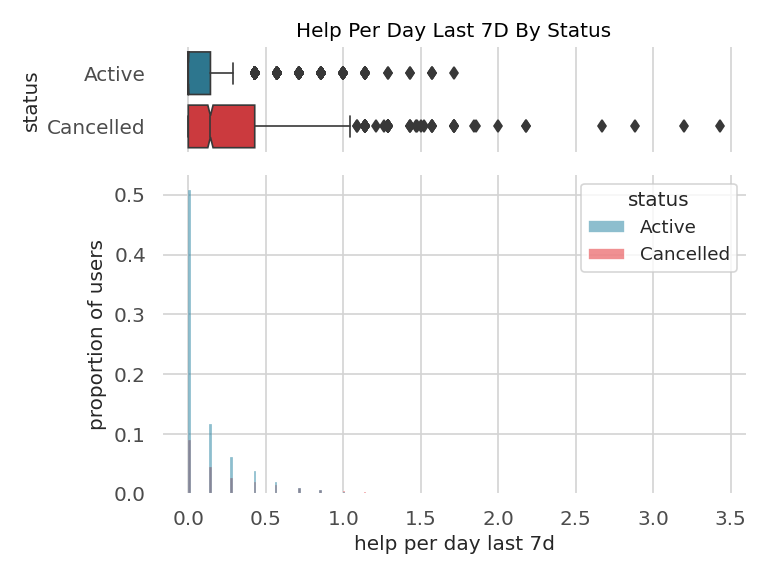

In [54]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='help_per_day_last_7d'
)
%matplot plt

### <a id='add_to_playlist'>[User Add To Playlist Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

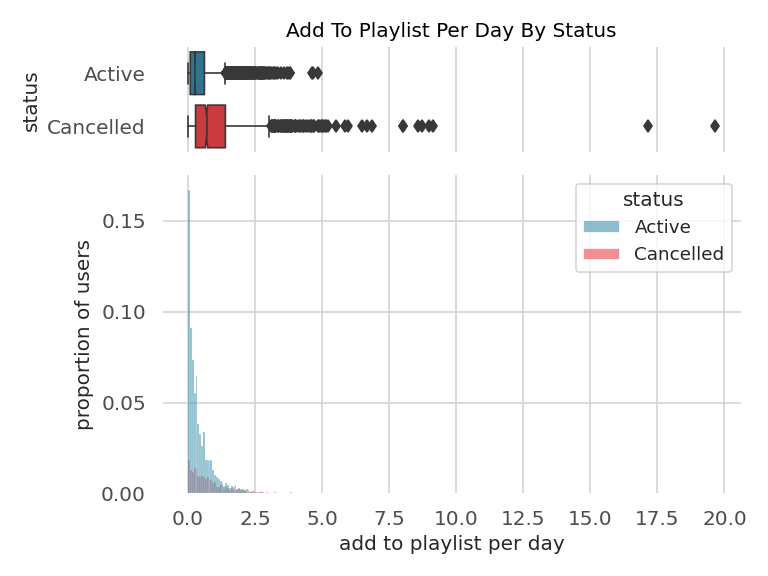

In [55]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='add_to_playlist_per_day'
)
%matplot plt

### <a id='add_to_playlist_last_7d'>[User Add To Playlist Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

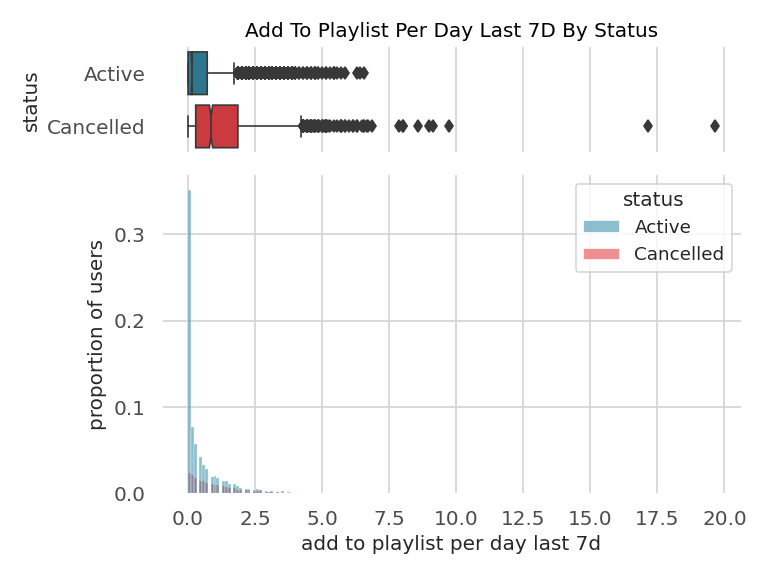

In [56]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='add_to_playlist_per_day_last_7d'
)
%matplot plt

### <a id='thumbs_up'>[User Thumbs Up Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

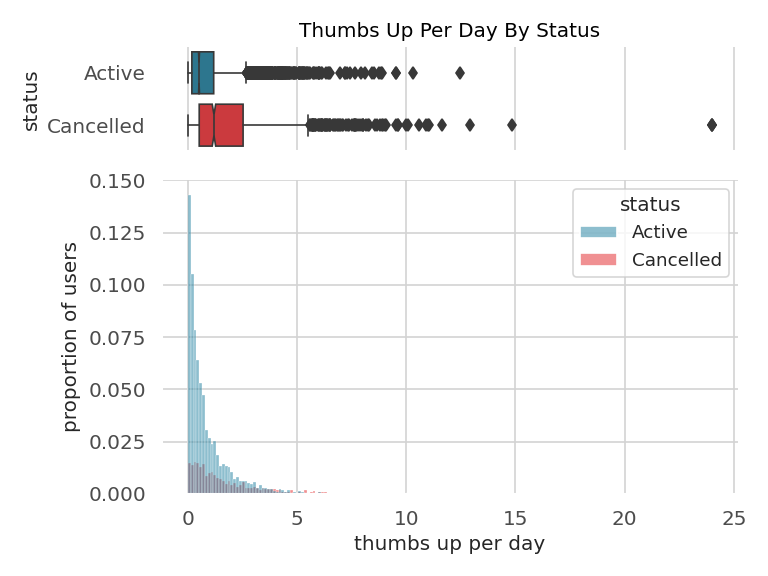

In [57]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_up_per_day'
)
%matplot plt

### <a id='thumbs_up_last_7d'>[User Thumbs Up Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

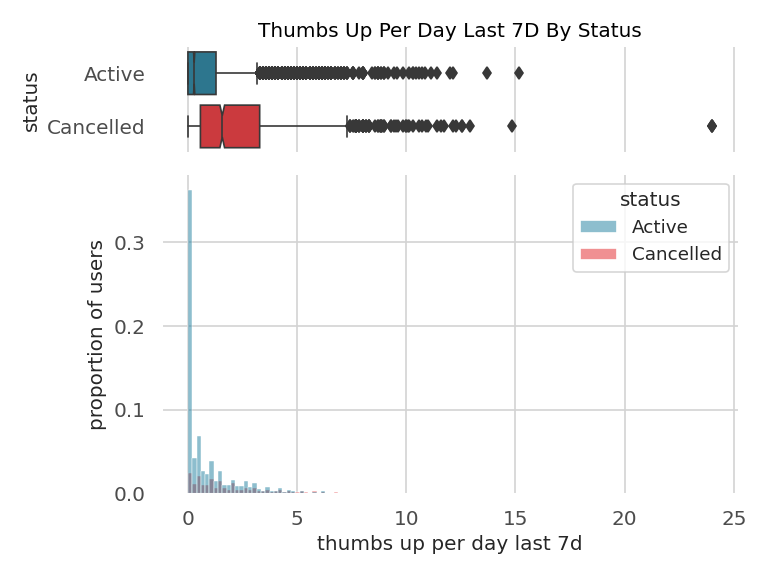

In [58]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_up_per_day_last_7d'
)
%matplot plt

### <a id='thumbs_down'>[Thumbs Down Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

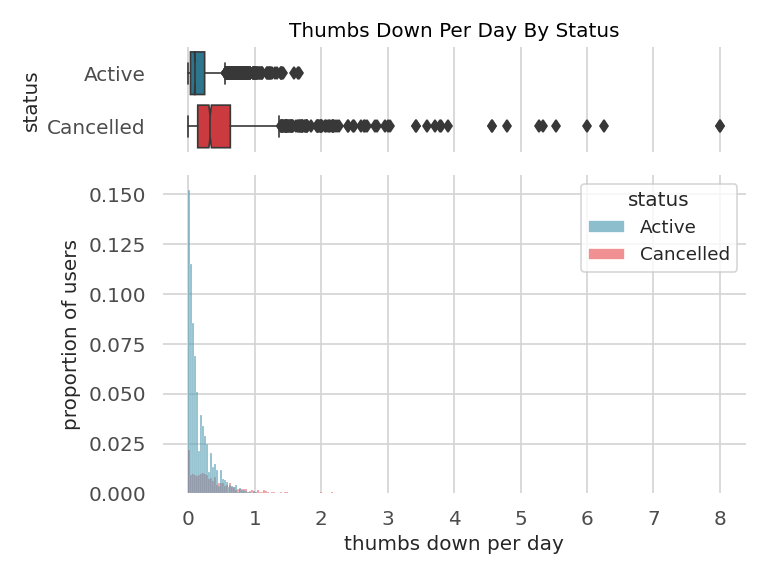

In [59]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_down_per_day'
)
%matplot plt

### <a id='thumbs_down_last_7d'>[Thumbs Down Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

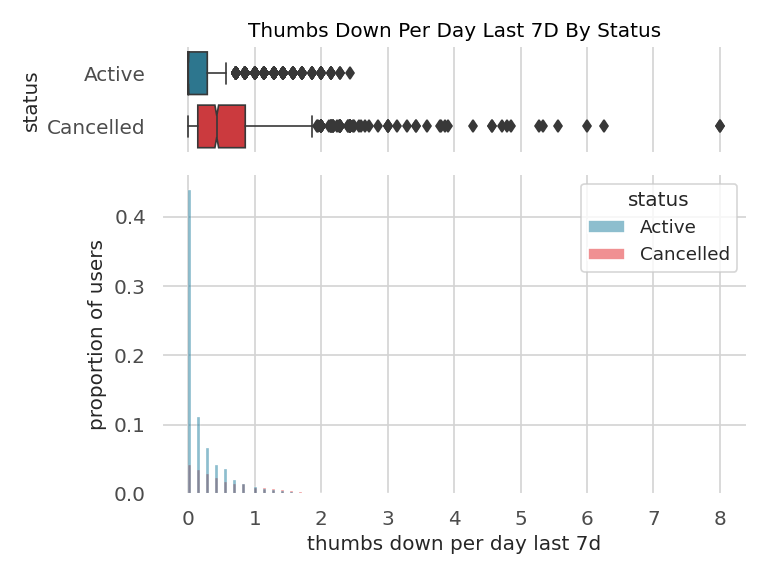

In [60]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_down_per_day_last_7d'
)
%matplot plt

### <a id='settings'>[User Settings Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

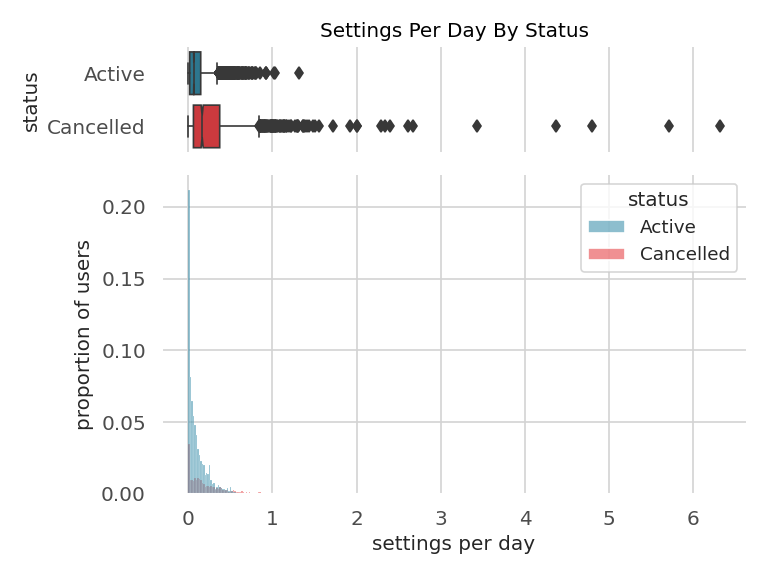

In [61]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='settings_per_day'
)
%matplot plt

### <a id='settings_last_7d'>[User Settings Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

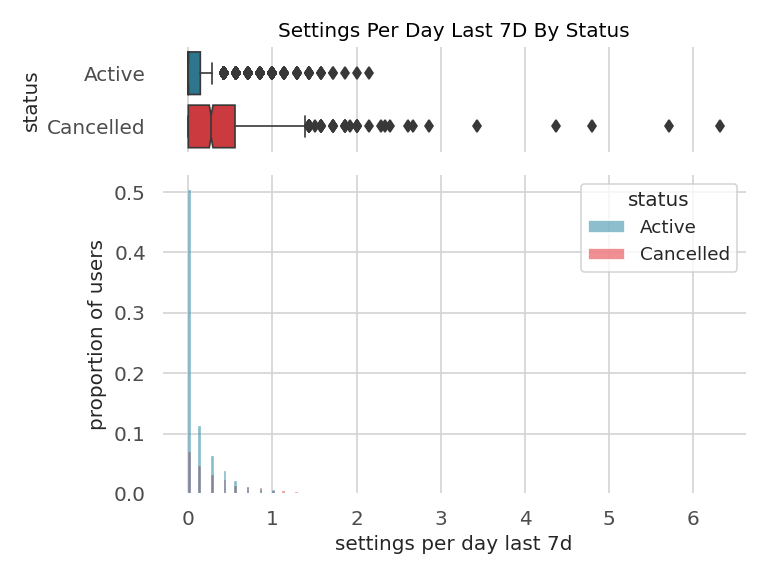

In [62]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='settings_per_day_last_7d'
)
%matplot plt

### <a id='save_settings'>[User Save Settings Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

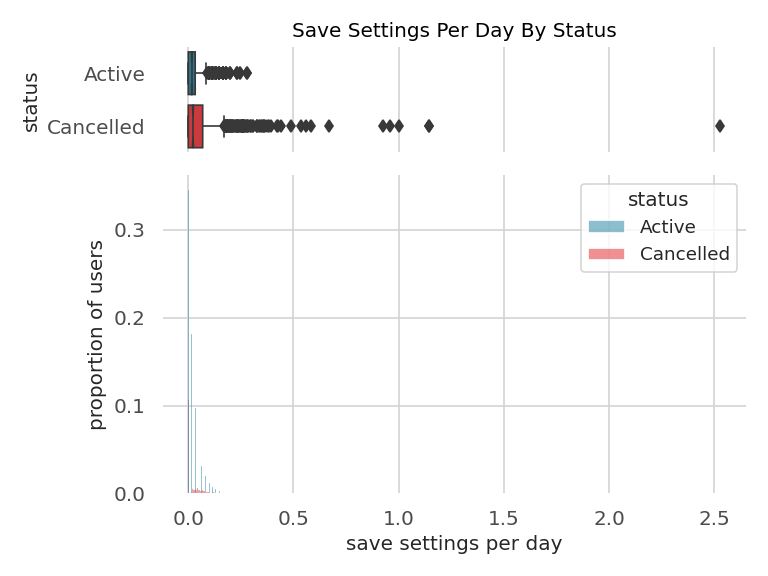

In [63]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='save_settings_per_day'
)
%matplot plt

### <a id='save_settings_last_7d'>[User Save Settings Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

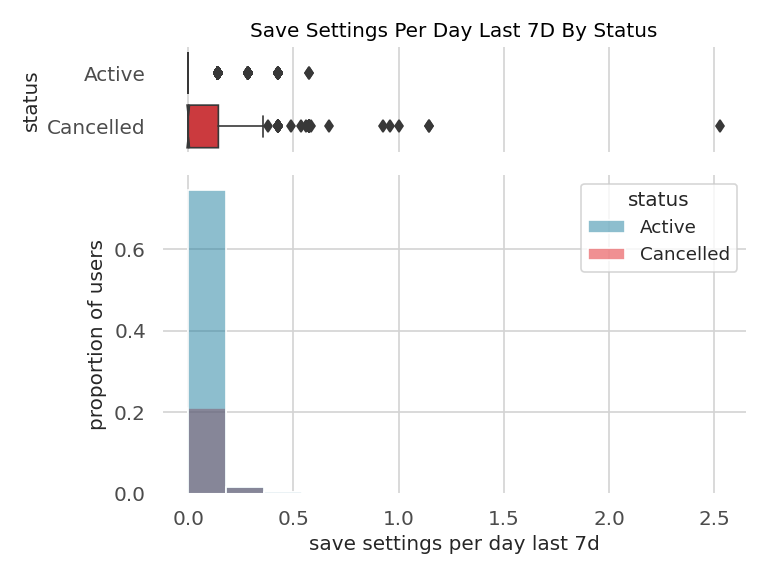

In [64]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='save_settings_per_day_last_7d'
)
%matplot plt

### <a id='about'>[User About Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

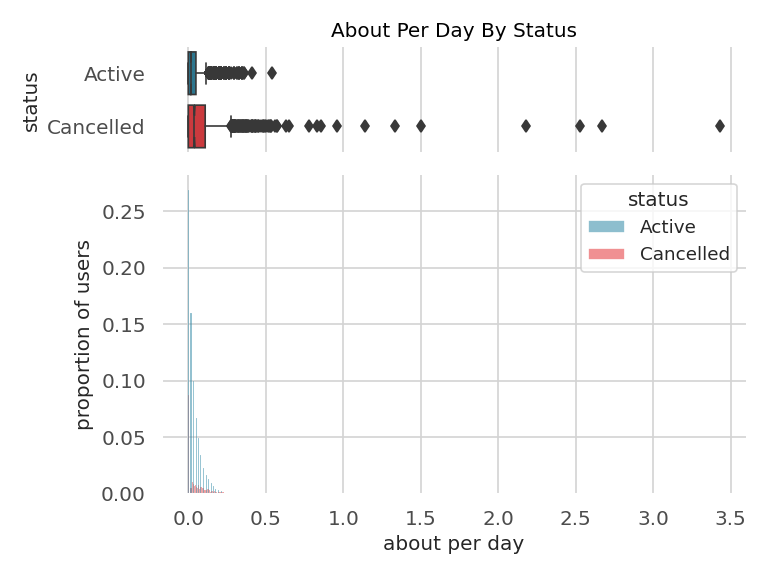

In [65]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='about_per_day'
)
%matplot plt

### <a id='about_last_7d'>[User About Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

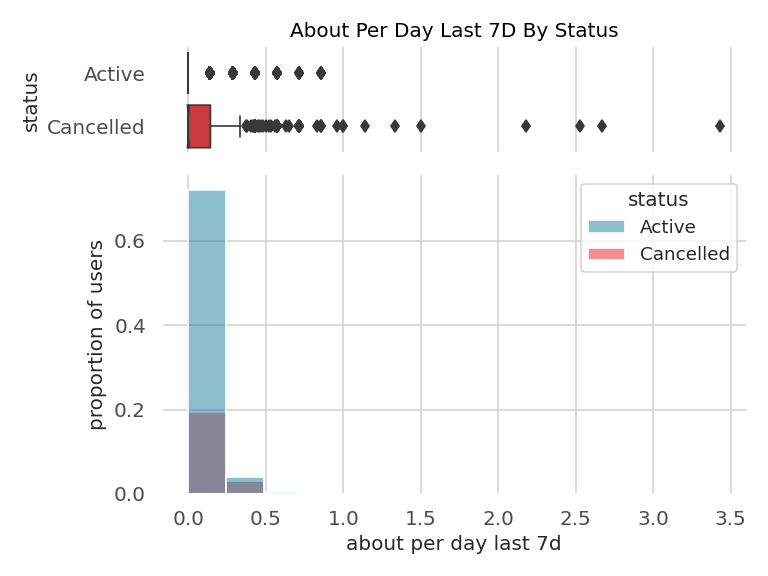

In [66]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='about_per_day_last_7d'
)
%matplot plt

### <a id='added_friends'>[User Added Friends Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

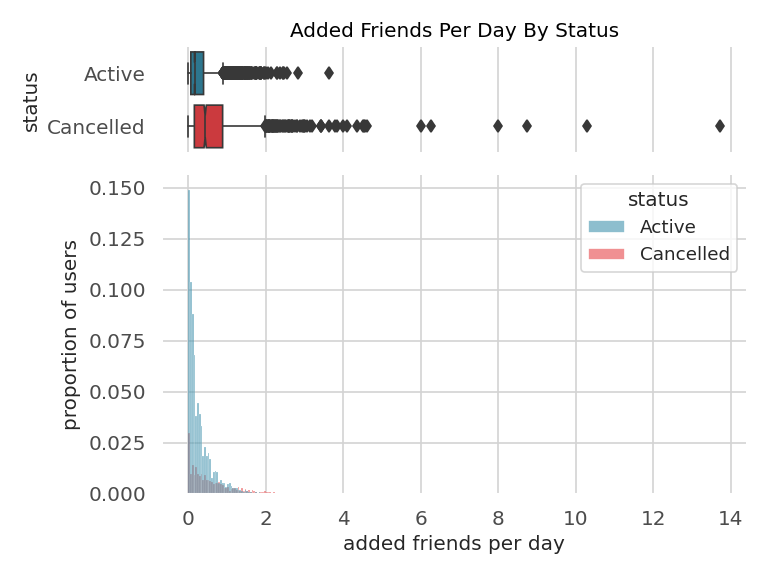

In [67]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='added_friends_per_day'
)
%matplot plt

### <a id='added_friends_last_7d'>[User Added Friends Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

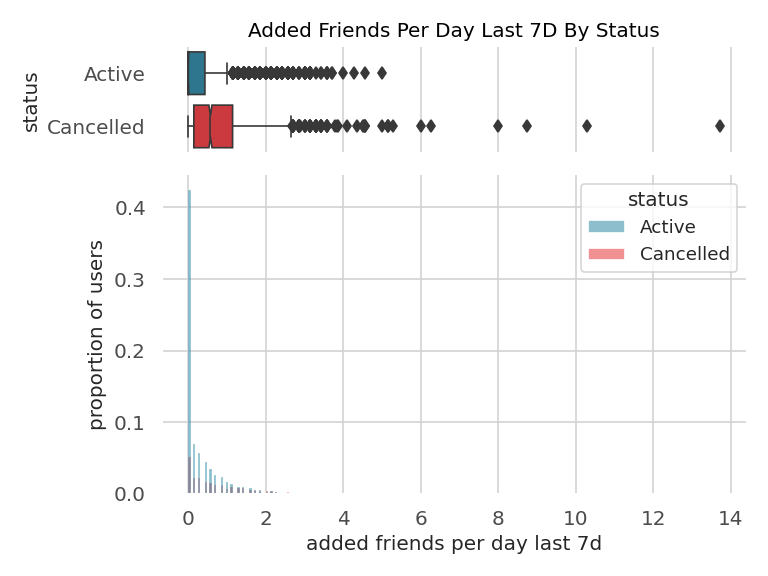

In [68]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='added_friends_per_day_last_7d'
)
%matplot plt

### <a id='sessions'>[User Sessions Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

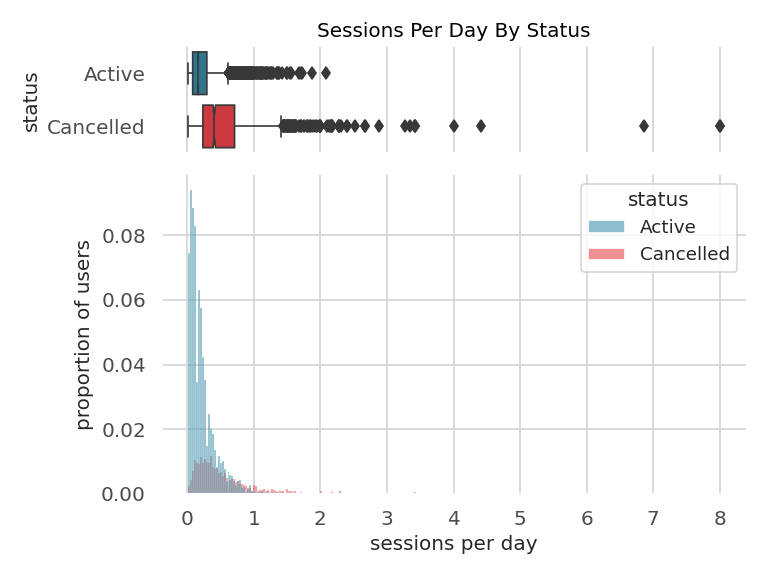

In [69]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='sessions_per_day'
)
%matplot plt

### <a id='sessions_last_7d'>[User Sessions Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

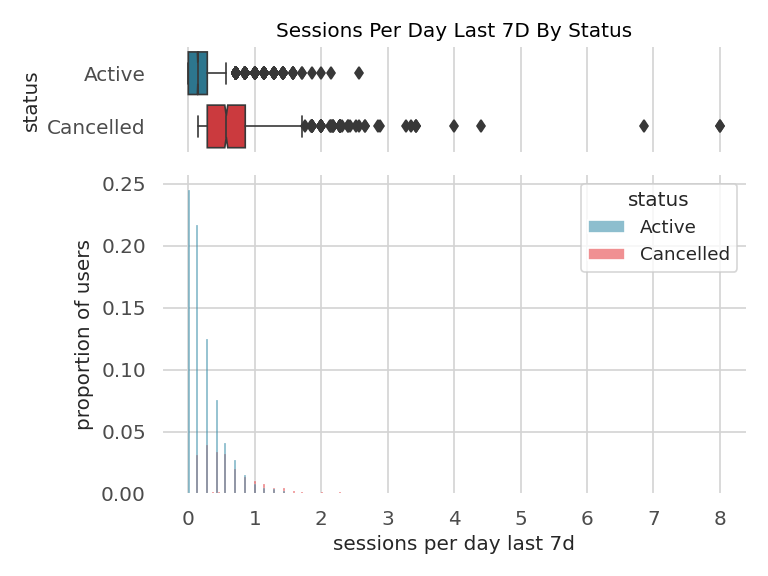

In [70]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='sessions_per_day_last_7d'
)
%matplot plt

### <a id='home'>[User Home Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

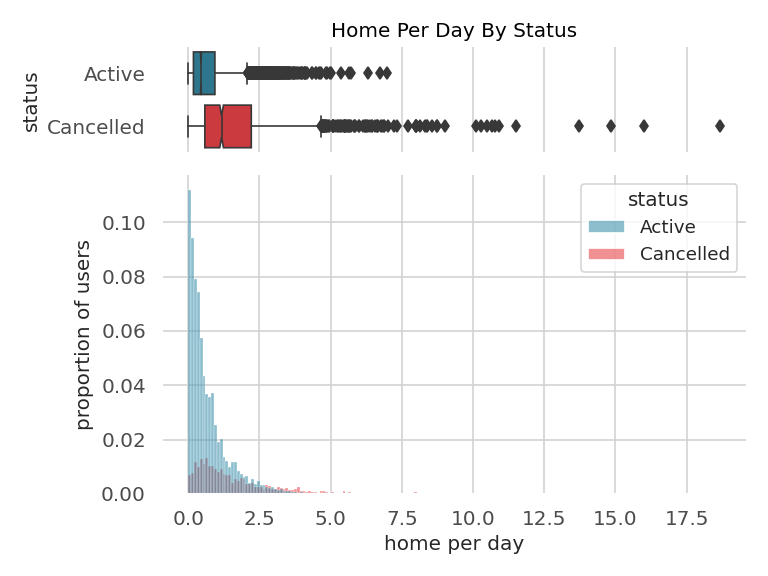

In [71]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='home_per_day'
)
%matplot plt

### <a id='home_last_7d'>[User Home Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

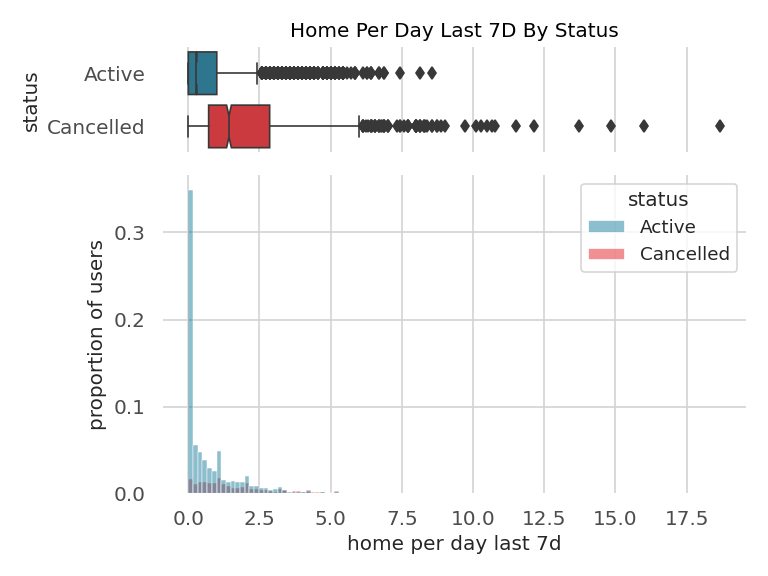

In [72]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='home_per_day_last_7d'
)
%matplot plt

### <a id='logouts'>[User Logouts Per Day By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

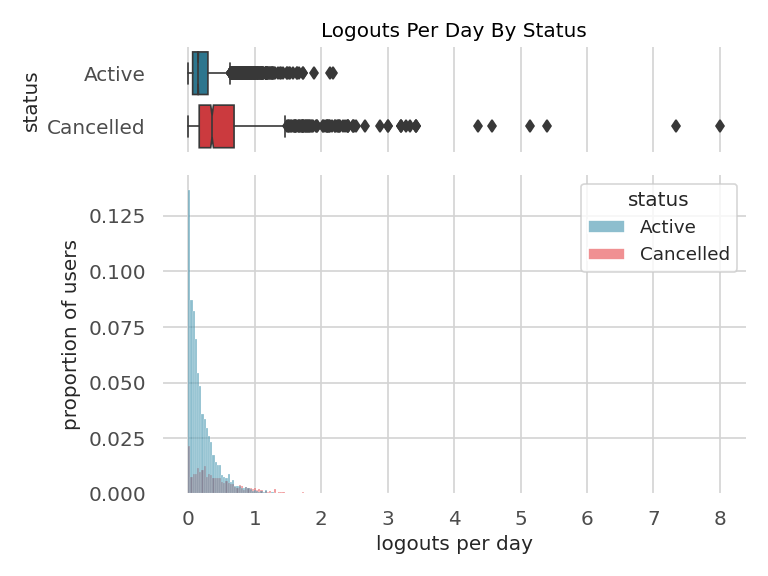

In [73]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='logouts_per_day'
)
%matplot plt

### <a id='logouts_last_7d'>[User Logouts Per Day (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

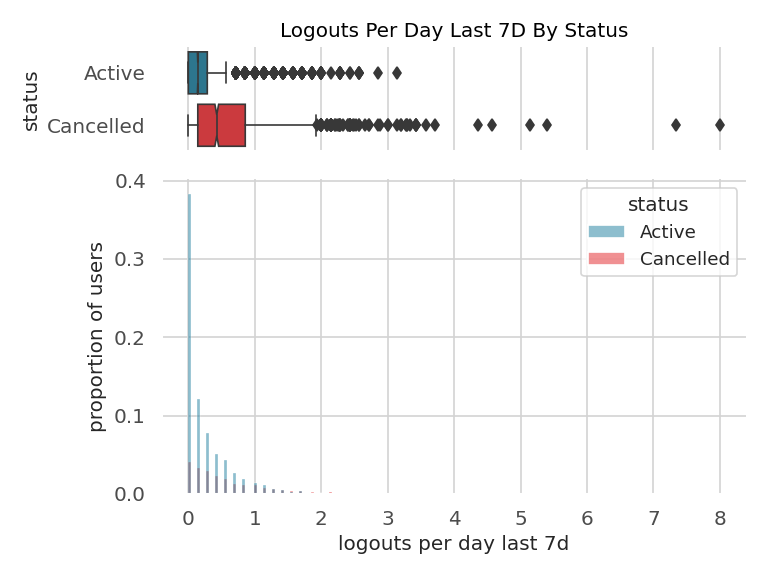

In [74]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='logouts_per_day_last_7d'
)
%matplot plt

### <a id='thumbs_up_per_next_song'>[User Thumbs Up Per Next Song By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

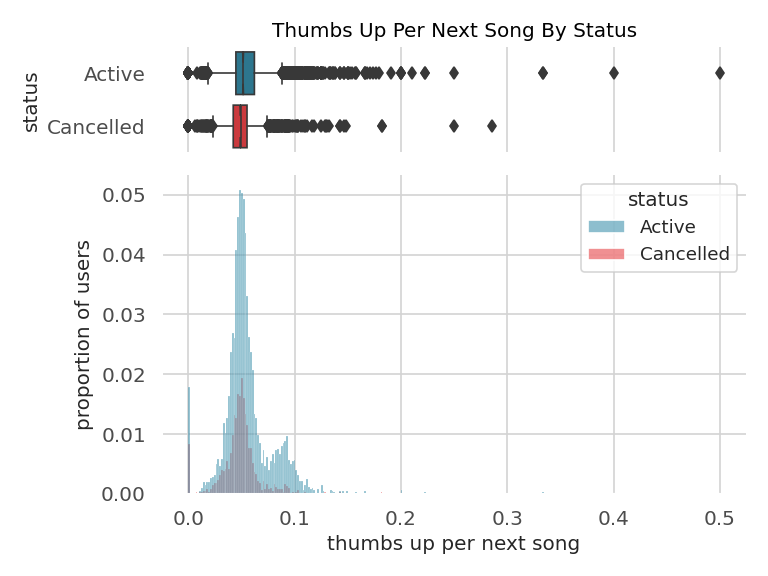

In [75]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_up_per_next_song'
)
%matplot plt

### <a id='thumbs_up_per_next_song_last_7d'>[User Thumbs Up Per Next Song (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

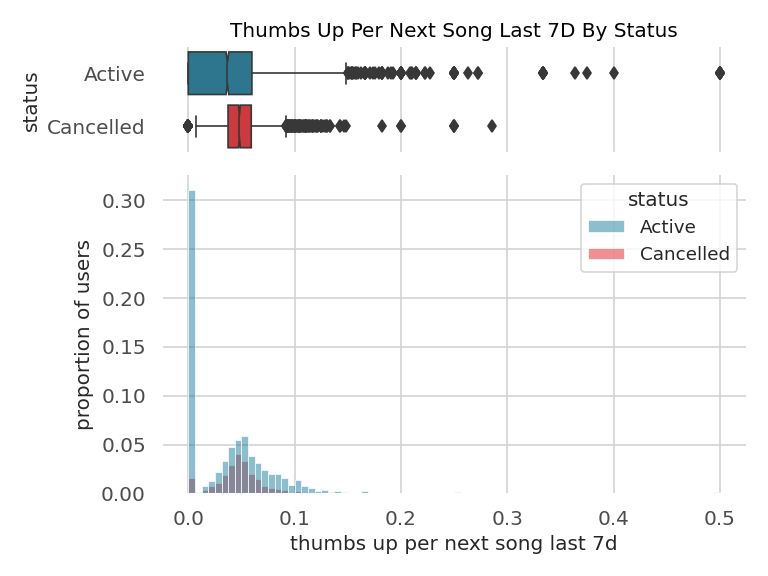

In [76]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_up_per_next_song_last_7d'
)
%matplot plt

### <a id='thumbs_down_per_next_song'>[User Thumbs Down Per Next Song By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

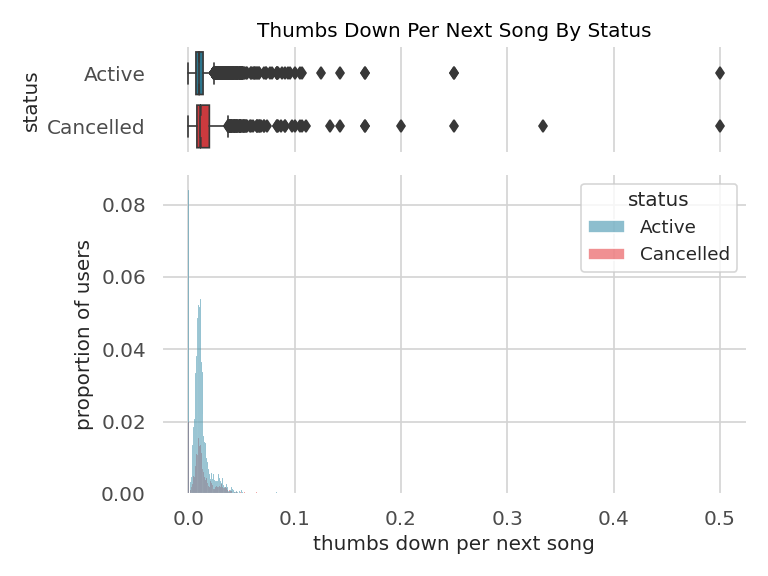

In [77]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_down_per_next_song'
)
%matplot plt

### <a id='thumbs_down_per_next_song_last_7d'>[User Thumbs Down Per Next Song (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

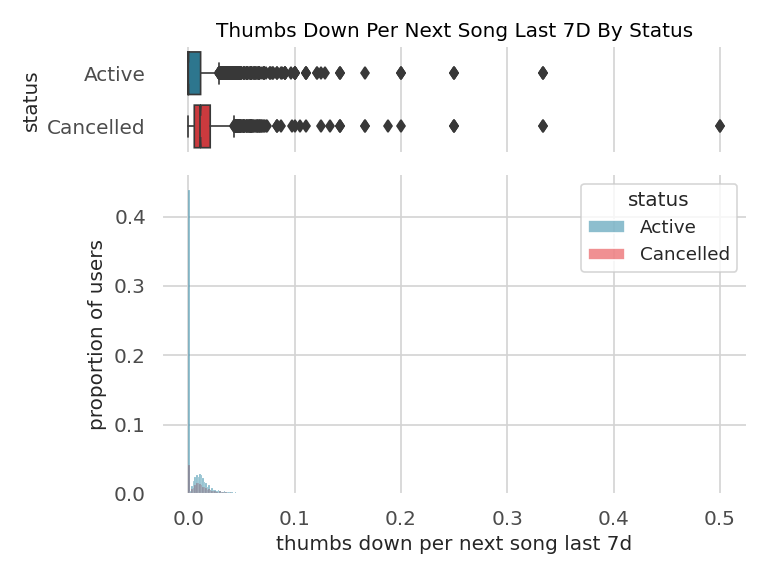

In [78]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='thumbs_down_per_next_song_last_7d'
)
%matplot plt

### <a id='add_to_playlist_per_next_song'>[User Add To Playlist Per Next Song By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

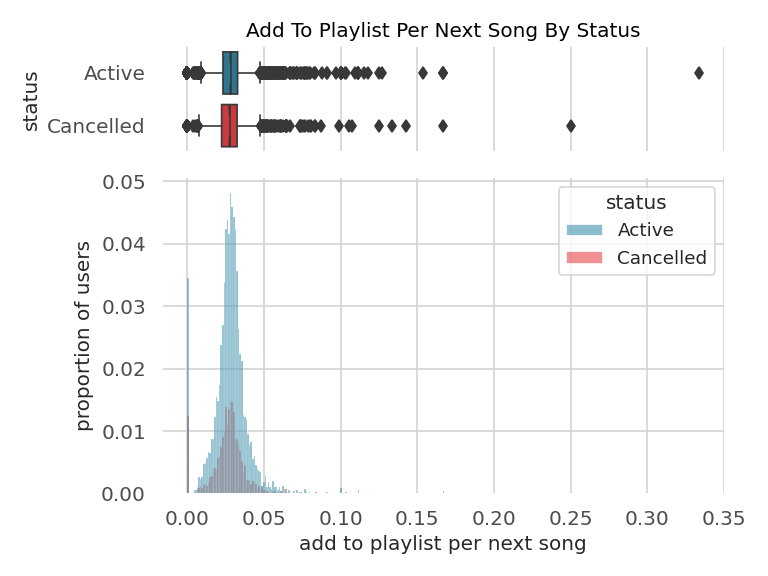

In [79]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='add_to_playlist_per_next_song'
)
%matplot plt

### <a id='add_to_playlist_per_next_song_last_7d'>[User Add To Playlist Per Next Song (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

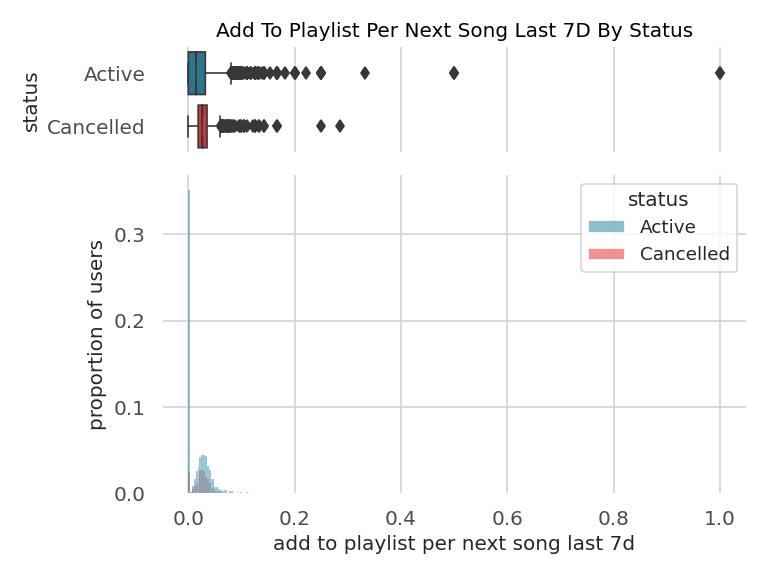

In [80]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='add_to_playlist_per_next_song_last_7d'
)
%matplot plt

### <a id='rolled_adverts_per_next_song'>[User Rolled Adverts Per Next Song By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

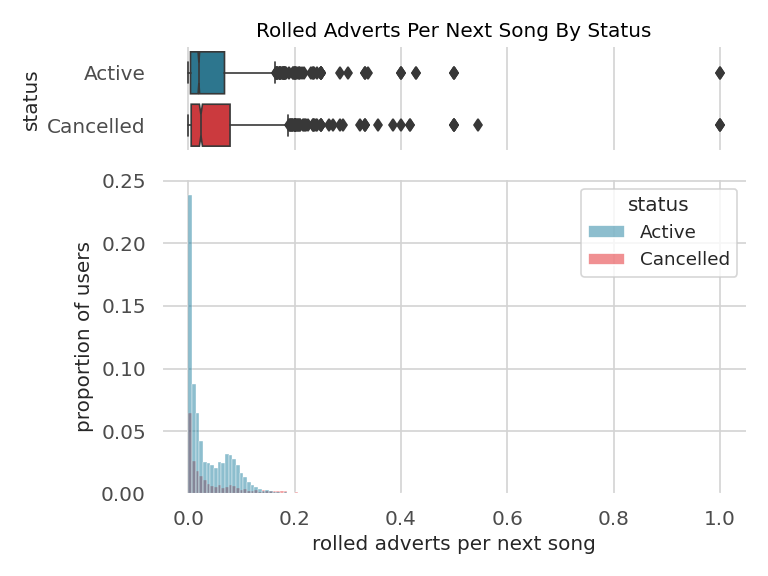

In [81]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='rolled_adverts_per_next_song'
)
%matplot plt

### <a id='rolled_adverts_per_next_song_last_7d'>[User Rolled Adverts Per Next Song (Last 7 Days) By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

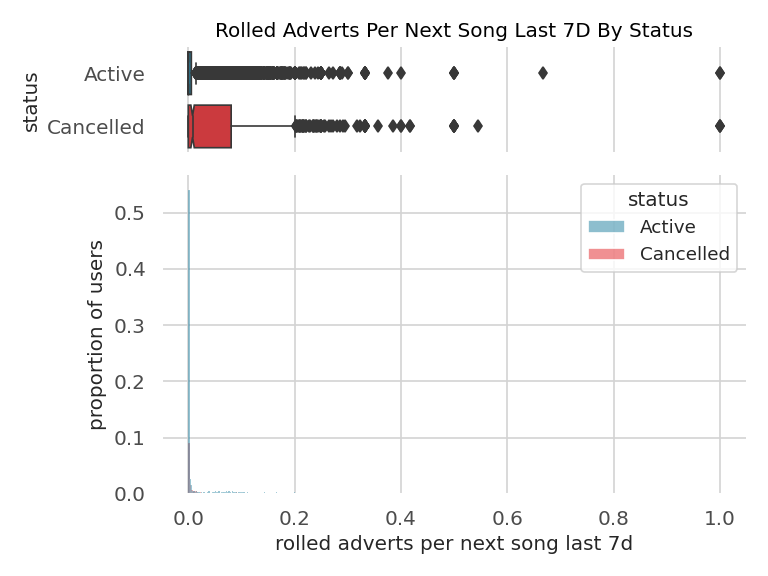

In [82]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='rolled_adverts_per_next_song_last_7d'
)
%matplot plt

### <a id='paid_days_active_per_days_active'>[Paid Days Active Per Days Active By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

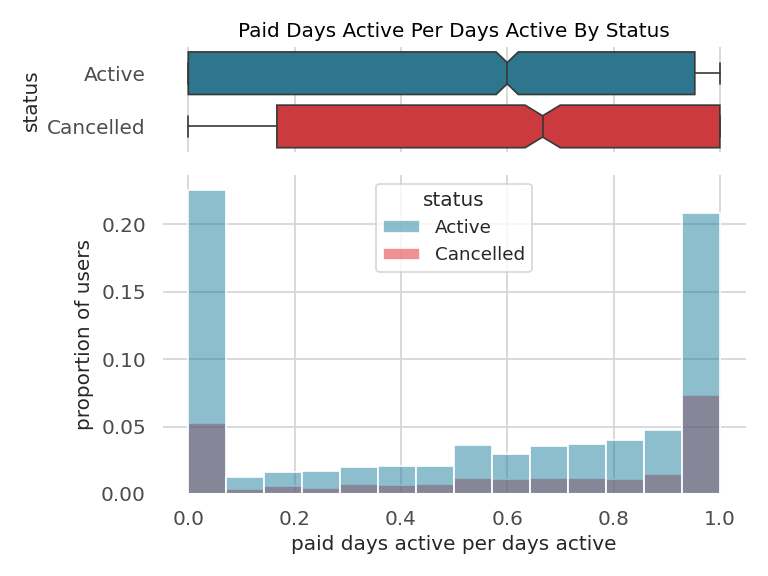

In [83]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='paid_days_active_per_days_active'
)
%matplot plt

### <a id='free_days_active_per_days_active'>[Free Days Active Per Days Active By Status</a>](#eda_plots)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

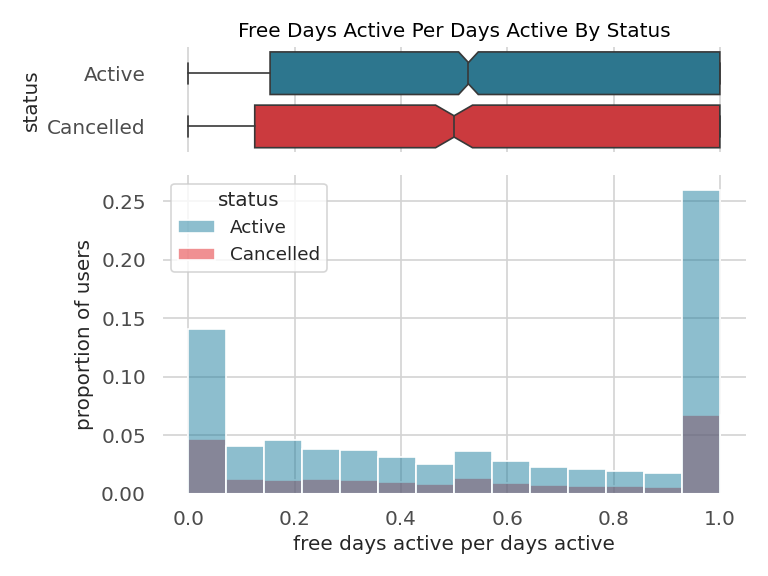

In [84]:
box_and_hist_plot_by_status(
    data=user_data_subset, 
    column='free_days_active_per_days_active'
)
%matplot plt

###  <a id='eda_summary'>[EDA Summary</a>](#eda)

- <b>Class Imbalance</b>
    - 22% of users `user_data` churned - amounts between 20-40% signify mild <a href="https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data">class imbalance</a>.
    

- <b>Features:</b>
    - <i><b>cohort</b></i>
        - Categorical Feature
        - Multiple values
        - 0% of values are missing
    - <i><b>days_registered</b></i>
        - Continuous Feature
        - Values between 0.42 and 412.04
        - 0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe moderate skew (right)
    - <i><b>proportion_of_days_active</b></i>
        - Continuous Feature
        - Values between 0.02 and 1.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>gender</b></i>
        - Categorical Feature
        - Assumes values: ('M' and 'F')
        - 0% of values are missing
        - Observe a difference in rate of churn between Male (26%) and Female (19%) users
    - <i><b>last_level</b></i>
        - Categorical Feature
        - Assumes values: ('Paid' and 'Free')
        - Observe a difference in rate of churn between Paid (21%) and Free (26%) users 
    - <i><b>browser</b></i>
        - Categorical Feature
        - Assumes values: ('Safari', 'Chrome', 'Firefox', 'Chromium' and 'Internet Explorer')
    - <i><b>operating system</b></i>
        - Categorical Feature
        - Assumes values: ('Mac', 'Windows', or 'Other')
        - The 'Other' category value only represents 5% of all categories
    - <i><b>device_type</b></i>
        - Categorical Feature
        - Assumes values: ('Mobile', 'Non-Mobile')
    - <i><b>next_songs_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 624.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>next_songs_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 624.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>upgrades_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 12.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>upgrades_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 12.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>downgrades_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>downgrades_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>submitted_upgrades_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 6.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>submitted_upgrades_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 6.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>submitted_downgrades_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 1.14
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>submitted_downgrades_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 1.14
        - 0.0% of values are missing 
        - Observe high skew (right)
    - <i><b>rolled_adverts_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 132.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>rolled_adverts_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 132.0
        - 0.0% of values are missing 
        - Observe high skew (right)
    - <i><b>errors_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 3.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>errors_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 3.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>help_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 8.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>help_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 8.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>add_to_playlist_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 48.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>add_to_playlist_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 48.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>thumbs_up_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 60.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>thumbs_up_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 60.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>thumbs_down_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>thumbs_down_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>settings_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 12.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>settings_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 12.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>save_settings_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 2.82
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>save_settings_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 2.82
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>about_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 8.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>about_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 8.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>added_friends_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 13.71
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>added_friends_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 13.71
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>sessions_per_day</b></i>
        - Continuous Feature
        - Values between 0.02 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>sessions_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>home_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 48.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>home_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 48.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>logouts_per_day</b></i>
        - Continuous Feature
        - Values between 0.0 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>logouts_per_day_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 24.0
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>thumbs_up_per_next_song</b></i>
        - Continuous Feature
        - Values between 0.0 and 0.5
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>thumbs_up_per_next_song_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 1.0
        - 0.0% of values are missing
        - Observe moderate skew (right)
    - <i><b>thumbs_down_per_next_song</b></i>
        - Continuous Feature
        - Values between 0.0 and 0.5
        - 0.0% of values are missing
        - Significant difference in medians between Cancelled and Active Users
        - Observe high skew (right)
    - <i><b>thumbs_down_per_next_song_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 0.5
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>add_to_playlist_per_next_song</b></i>
        - Continuous Feature
        - Values between 0.0 and 0.33
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>add_to_playlist_per_next_song_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 1.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>rolled_adverts_per_next_song</b></i>
        - Continuous Feature
        - Values between 0.0 and 1.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>rolled_adverts_per_next_song_last_7d</b></i>
        - Continuous Feature
        - Values between 0.0 and 1.0
        - 0.0% of values are missing
        - Observe high skew (right)
    - <i><b>free_days_active_per_days_active</b></i>
        - Continuous Feature
        - 0.0% of values are missing
        - Values between 0.0 and 1.0
    - <i><b>paid_days_active_per_days_active</b></i>
        - Continuous Feature
        - 0.0% of values are missing
        - Values between 0.0 and 1.0

# <a id='feature_engineering'>[Feature Engineering</a>](#project_sections)

- [Defining Encodings for Features](#feature_encoding)
- [Defining Classification Models](#defining_classification_models)
- [Defining Pipelines](#defining_pipelines)
- [Defining Cross Validator](#defining_cross_validator)

### <a id='feature_encoding'>[Defining Encodings for Features</a>](#feature_engineering)
- Creating an instance of `CategoricalTransformer`, which uses a StringIndexer and OneHotEncoder from `spark.ml.features` to One-Hot Encoder the categorical features in the Sparkify dataset.
- Creating an instance of `NumericTransformer` which uses (a VectorAssembler and RobustScaler) for adding Numeric Features to vector and scaling them.
- Defining a final VectorAssembler for combining all the transformed features.

In [8]:
numeric_columns = [
    'next_songs_per_day', 'rolled_adverts_per_day', 'submitted_downgrades_per_day',
    'submitted_upgrades_per_day', 'help_per_day', 'errors_per_day', 'thumbs_up_per_day',
    'thumbs_down_per_day', 'add_to_playlist_per_day', 'about_per_day', 
    'settings_per_day', 'save_settings_per_day', 'upgrades_per_day', 
    'downgrades_per_day', 'added_friends_per_day', 'sessions_per_day', 
    'session_hours_per_day', 'home_per_day', 'logouts_per_day', 
    'free_days_active_per_days_active', 'paid_days_active_per_days_active',
    'days_registered', 'proportion_of_days_active', 'next_songs_per_day_last_7d', 
    'rolled_adverts_per_day_last_7d', 'save_settings_per_day_last_7d', 'home_per_day_last_7d', 
    'settings_per_day_last_7d', 'about_per_day_last_7d', 'logouts_per_day_last_7d', 
    'errors_per_day_last_7d', 'help_per_day_last_7d', 'submitted_downgrades_per_day_last_7d',
    'submitted_upgrades_per_day_last_7d', 'downgrades_per_day_last_7d', 'upgrades_per_day_last_7d',
    'thumbs_up_per_day_last_7d', 'thumbs_down_per_day_last_7d', 'add_to_playlist_per_day_last_7d',
    'added_friends_per_day_last_7d', 'sessions_per_day_last_7d', 'rolled_adverts_per_next_song', 
    'rolled_adverts_per_next_song_last_7d', 'thumbs_up_per_next_song', 'thumbs_up_per_next_song_last_7d',
    'thumbs_down_per_next_song', 'thumbs_down_per_next_song_last_7d', 'add_to_playlist_per_next_song', 
    'add_to_playlist_per_next_song_last_7d'
]

numeric_transformer = NumericTransformer(
    columns=numeric_columns,
    scaler=RobustScaler
)


categorical_columns = [
    'gender', 'browser', 'os', 'last_level', 'cohort', 'device_type'
]

categorical_transformer = CategoricalTransformer(
    columns=categorical_columns,
    string_indexer_settings={
        'handleInvalid': 'keep'
    }
)


# Assembling all of the features into a vector.
final_assembler = VectorAssembler(
    inputCols=[
        'gender_idx_ohe', 'browser_idx_ohe', 'os_idx_ohe',
        'last_level_idx_ohe', 'cohort_idx_ohe', 'device_type_idx_ohe',
        'scaled_features'
    ],
    outputCol='features' 
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <a id='defining_classification_models'>[Defining Classification Models</a>](#feature_engineering)

In [9]:
# Logistic Regression Model.
lr = LogisticRegression(
    featuresCol='features',
    labelCol='churn'
)

# Decision Tree Classifier.
dt = DecisionTreeClassifier(
    featuresCol='features',
    labelCol='churn'
)

# Random Forest Classifier.
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='churn'
)

# Gradient Boosting Classifier.
gb = GBTClassifier(
    featuresCol='features', 
    labelCol='churn'
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <a id='defining_pipelines'>[Defining Pipelines</a>](#feature_engineering)
Defining stages for each ML model pipeline.

In [10]:
# Defining stages for each ML model pipeline.
# Base pipeline stages.
base_pipeline_stages = [
    categorical_transformer.string_indexer,
    categorical_transformer.one_hot_encoder,
    numeric_transformer.vector_assembler,
    numeric_transformer.scaler,
    final_assembler
]

# Logistic Regression pipeline stages.
lr_pipeline_stages = base_pipeline_stages + [lr]

# Decision Tree pipeline stages.
dt_pipeline_stages = base_pipeline_stages + [dt]

# Random Forest pipeline stages.
rf_pipeline_stages = base_pipeline_stages + [rf]

# Gradient Boosting pipeline stages.
gb_pipeline_stages = base_pipeline_stages + [gb]

# Setting Formula.
formula = RFormula(formula = 'churn ~ .')

# Setting Pipeline With formula.
pipeline = Pipeline(stages=[formula])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Defining Parameter Grids for each ML pipeline.

In [11]:
# Parameter Grid For Logistic Regression.
lr_param_grid = (
    ParamGridBuilder()
    .baseOn({pipeline.stages : lr_pipeline_stages})
    .addGrid(lr.regParam, [100, 10, 1, 0.1, 0.01])
    .build()
)

# Parameter Grid For Decision Tree Classifier.
dt_param_grid = (
    ParamGridBuilder()
    .baseOn({pipeline.stages: dt_pipeline_stages})
    .addGrid(dt.maxDepth, [3, 5, 7])
    .build()
)

# Parameter Grid For Random Forest Classifier.
rf_param_grid = (
    ParamGridBuilder()
    .baseOn({pipeline.stages: rf_pipeline_stages})
    .addGrid(rf.maxDepth, [3, 5, 7])
    .build()
)

# Parameter Grid For Gradient Boosting Classifier.
gb_param_grid = (
    ParamGridBuilder()
    .baseOn({pipeline.stages: gb_pipeline_stages})
    .addGrid(gb.maxDepth, [3, 5, 7])
    .build()
)

# Combining the Parameter Grids 
param_grid = lr_param_grid + dt_param_grid + rf_param_grid + gb_param_grid

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <a id='defining_cross_validator'>[Defining Cross Validator</a>](#feature_engineering)

In [21]:
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=(
        BinaryClassificationEvaluator(
            metricName='areaUnderPR'
        ).setLabelCol('churn')
    ),
    numFolds=3,
    collectSubModels=True
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-21:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



# <a id='modeling'>[Modeling</a>](#project_sections)

- [Train Test Split](#train_test_split)
- [Fitting Model With Cross Validation](#fitting_model)
- [Predicting With Fitted Model](#predicting_with_model)
- [Model Results](#model_results)
- [Best Model](#best_model)

### <a id='train_test_split'>[Train Test Split</a>](#modeling)

In [13]:
train, test = user_data.randomSplit([0.8, 0.2], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <a id='fitting_model'>[Fitting Model With Cross Validation](#modeling)

In [22]:
cv_model = crossval.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-22:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



### <a id='predicting_with_model'>[Predicting With Fitted Model](#modeling)

In [77]:
predictions = cv_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <a id='model_results'>[Model Results](#modeling)

In [ ]:
# Query for calculating F1 score, accuracy, etc.
GET_MODEL_METRICS = """
WITH prediction_labels AS
(
    SELECT
        label, COUNT(*) AS count
    FROM 
        (
        SELECT
            CASE 
            WHEN churn = 1 AND INT(prediction) = 1 THEN 'TP'
            WHEN churn = 0 AND INT(prediction) = 0 THEN 'TN'
            WHEN churn = 0 AND INT(prediction) = 1 THEN 'FP'
            ELSE 'FN'
            END AS label
        FROM {table}
        )
    GROUP BY label
),
pivoted_prediction_labels AS (
    SELECT 
        IFNULL(TP, 0) AS TP,
        IFNULL(FP, 0) AS FP,
        IFNULL(FN, 0) AS FN,
        IFNULL(TN, 0) AS TN
    FROM
    (
      SELECT label, count
      FROM prediction_labels
    ) sub
    PIVOT
    (
      FIRST_VALUE(count)
      FOR label IN ('TP', 'FP', 'FN', 'TN')
    )
),

preliminary_calculations AS (
SELECT 
    COALESCE(TP/(TP + FP), 0) AS precision,
    COALESCE(TP/(TP + FN), 0) AS recall,
    COALESCE((TP + TN)/(TP + TN + FP + FN), 0) AS accuracy,
    TP,
    FP,
    TN,
    FN
FROM pivoted_prediction_labels
)

SELECT
    ROUND(precision, 2) AS precision,
    ROUND(recall, 2) AS recall,
    ROUND(
        COALESCE((2 * precision * recall)/(precision + recall), 0), 
    2) AS F1_score,
    ROUND(accuracy, 2) AS accuracy,
    TP,
    FP,
    TN,
    FN
FROM preliminary_calculations
"""

In [101]:
model_results = {}
for pipeline_list in cv_model.subModels:
    for pipeline_ in pipeline_list:
        if isinstance(pipeline_.stages[-1], LogisticRegressionModel):
            model='LR_regParam_{}'.format(pipeline_.stages[-1].getRegParam())
                
        elif isinstance(pipeline_.stages[-1], RandomForestClassificationModel):
            model='RF_maxDepth_{}'.format(pipeline_.stages[-1].getMaxDepth())
        
        elif isinstance(pipeline_.stages[-1], DecisionTreeClassificationModel):
            model='DT_maxDepth_{}'.format(pipeline_.stages[-1].getMaxDepth())

        
        elif isinstance(pipeline_.stages[-1], GBTClassificationModel):
            model='GBT_maxDepth_{}'.format(pipeline_.stages[-1].getMaxDepth())

        
        predictions_and_labels=pipeline_.transform(test).select(['prediction', 'churn'])
        result = spark.sql(QUERY, table=predictions_and_labels)
        model_results[model] = result

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
for key, model_result in model_results.items():
    print('Model: {}'.format(key))
    model_results[key].show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-102:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 91474



Model: LR_regParam_100.0
+---------+------+--------+--------+---+---+----+----+
|precision|recall|F1_score|accuracy| TP| FP|  TN|  FN|
+---------+------+--------+--------+---+---+----+----+
|      0.0|   0.0|     0.0|    0.77|  0|  0|3499|1016|
+---------+------+--------+--------+---+---+----+----+

Model: LR_regParam_10.0
+---------+------+--------+--------+---+---+----+---+
|precision|recall|F1_score|accuracy| TP| FP|  TN| FN|
+---------+------+--------+--------+---+---+----+---+
|      1.0|  0.02|    0.03|    0.78| 18|  0|3499|998|
+---------+------+--------+--------+---+---+----+---+

Model: LR_regParam_1.0
+---------+------+--------+--------+---+---+----+---+
|precision|recall|F1_score|accuracy| TP| FP|  TN| FN|
+---------+------+--------+--------+---+---+----+---+
|     0.81|  0.19|     0.3|    0.81|190| 44|3455|826|
+---------+------+--------+--------+---+---+----+---+

Model: LR_regParam_0.1
+---------+------+--------+--------+---+---+----+---+
|precision|recall|F1_score|accura

### <a id='best_model'>[Best Model](#modeling)

In [127]:
# Selecting best model
best_model = cv_model.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [129]:
# Best Classifier.
best_model.stages[-1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

GBTClassificationModel: uid = GBTClassifier_658424d80a43, numTrees=20, numClasses=2, numFeatures=77

In [125]:
# Get Max Depth.
best_model.stages[-1].getMaxDepth()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

7